##### Cumulative Reward Old

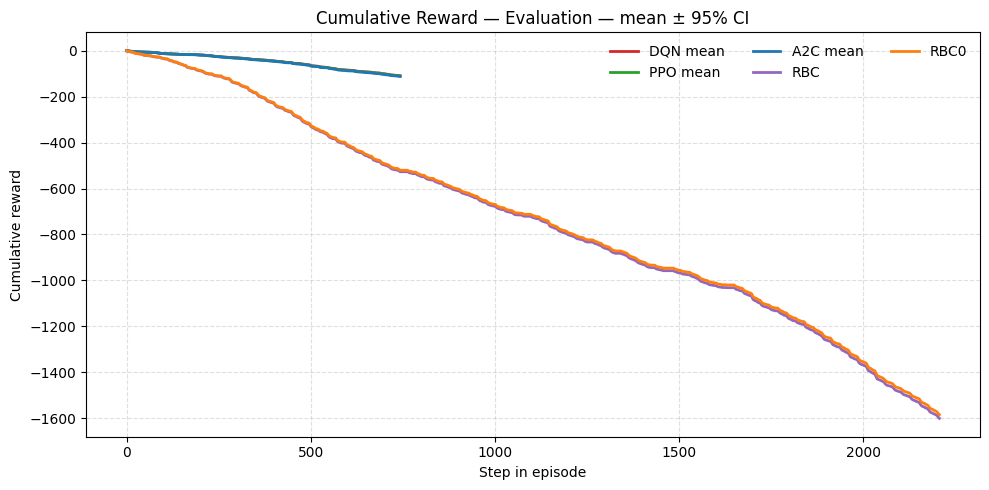

/scratch/slurm_tmpdir/job_1560401/ipykernel_2486815/3900888893.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


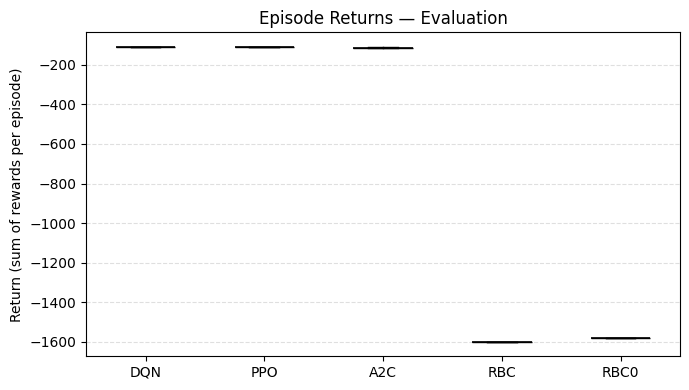

/scratch/slurm_tmpdir/job_1560401/ipykernel_2486815/3900888893.py:206: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


DQN  : mean=-109.27, std=0.03, n=10
PPO  : mean=-110.07, std=0.23, n=10
A2C  : mean=-112.31, std=0.77, n=10
RBC  : mean=-1600.19, std=0.00, n=10
RBC0 : mean=-1584.09, std=0.00, n=10


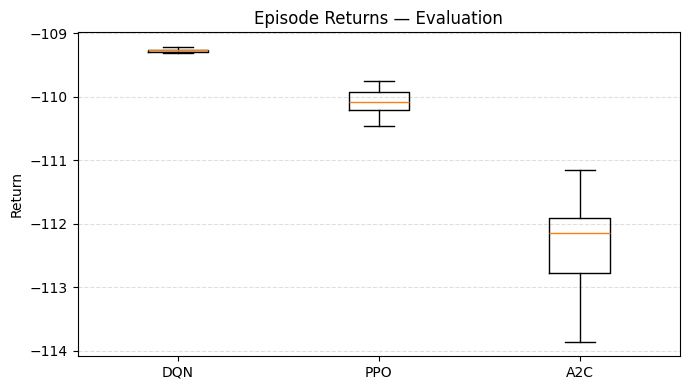

DQN: mean=-109.27 ± 0.03 (n=10)
PPO: mean=-110.07 ± 0.23 (n=10)
A2C: mean=-112.31 ± 0.77 (n=10)


In [1]:
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Pfade (aus deinem Setup) ----
DQN_EVAL_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/dqn/dqn_split_10eval_final_not_deterministic.pkl'
PPO_EVAL_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_split_10eval_final_not_deterministic.pkl'
A2C_EVAL_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_split_10eval_final_not_deterministic.pkl'
RBC_LOG_FILE   = r'/hkfs/home/haicore/iai/cj9272/logs/rbc/rbc_agent_logs_10episodes.csv'
RBC0_LOG_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/rbc0/rbc0_agent_logs_10episodes.csv'

COLOR = {"DQN":"C3","PPO":"C2","A2C":"C0","RBC":"C4","RBC0":"C1"}

# ---------- Loader ----------
def _to1f(x): return np.asarray(x, float).ravel()

def all_episode_step_rewards_from_pkl(path):
    """Gibt Liste[np.ndarray] der per-step Rewards je Episode zurück."""
    with open(path, "rb") as f:
        d = pickle.load(f)
    if isinstance(d, dict):
        if "ep_rewards_list" in d:
            ep = d["ep_rewards_list"]
            if len(ep) and isinstance(ep[0], (list, tuple, np.ndarray)):
                return [ _to1f(e) for e in ep ]
            else:
                # ep_rewards_list enthält schon Episode-Returns -> als 1-Step-Episoden verpacken
                return [ _to1f([v]) for v in _to1f(d["ep_rewards_list"]) ]
        if "step_rewards" in d and "ep_lengths" in d:
            steps = _to1f(d["step_rewards"]); lens = np.asarray(d["ep_lengths"], int).ravel()
            offs = np.cumsum(np.concatenate([[0], lens[:-1]]))
            return [ steps[o:o+l] for o,l in zip(offs, lens) ]
    raise ValueError(f"Unbekanntes Format: {path}")

def all_episode_step_rewards_from_csv(path):
    """RBC/RBC0 CSV -> Liste per-step Rewards pro Episode."""
    df = pd.read_csv(path)
    if 'episode' not in df.columns or 'reward' not in df.columns:
        raise KeyError("CSV braucht 'episode' und 'reward'.")
    df = df.sort_values(['episode', 'timestep' if 'timestep' in df.columns else df.index.name or df.index]).reset_index(drop=True)
    out = []
    for ep, grp in df.groupby('episode'):
        out.append(grp['reward'].to_numpy(float))
    return out

def mean_ci_cumcurves(list_of_step_rewards):
    """Gleicht Länge an (min), berechnet mean & 95% CI der kum. Rewards."""
    if not list_of_step_rewards:
        return None
    L = min(len(r) for r in list_of_step_rewards)
    M = np.vstack([np.cumsum(r[:L]) for r in list_of_step_rewards])
    mean = M.mean(axis=0)
    sem  = M.std(axis=0, ddof=1) / np.sqrt(M.shape[0]) if M.shape[0] > 1 else np.zeros_like(mean)
    ci95 = 1.96 * sem
    return mean, ci95

def episode_returns(list_of_step_rewards):
    return np.array([np.sum(r) for r in list_of_step_rewards], float)

# ---------- Daten laden ----------
sources = {
    "DQN":  ("pkl", DQN_EVAL_FILE),
    "PPO":  ("pkl", PPO_EVAL_FILE),
    "A2C":  ("pkl", A2C_EVAL_FILE),
    "RBC":  ("csv", RBC_LOG_FILE),
    "RBC0": ("csv", RBC0_LOG_FILE),
}
curves = {}   # name -> (mean, ci)  oder (line, None) falls nur eine Episode
returns = {}  # name -> np.array per-episode returns

for name, (kind, path) in sources.items():
    if not Path(path).exists():
        print(f"[Warn] fehlt: {name} -> {path}"); continue
    if kind == "pkl":
        eps = all_episode_step_rewards_from_pkl(path)
    else:
        eps = all_episode_step_rewards_from_csv(path)
    returns[name] = episode_returns(eps)
    mc = mean_ci_cumcurves(eps)
    if mc is None: 
        continue
    mean, ci = mc
    curves[name] = (mean, ci if len(eps) > 1 else None)

# ---------- FIGURE 1: Cumulative Reward (mean ± 95% CI) ----------
plt.figure(figsize=(10,5))
for name in ["DQN","PPO","A2C"]:
    if name in curves:
        mean, ci = curves[name]
        x = np.arange(len(mean))
        plt.plot(x, mean, lw=2, label=f"{name} mean", color=COLOR[name])
        if ci is not None and np.any(ci):
            plt.fill_between(x, mean-ci, mean+ci, alpha=0.15, linewidth=0, color=COLOR[name])

# RBC/RBC0 als Einzellinien (falls mehrere Episoden vorhanden, zeigen wir nur den Mean ohne Band – sonst erschlägt’s)
for name in ["RBC","RBC0"]:
    if name in curves:
        mean, ci = curves[name]
        x = np.arange(len(mean))
        plt.plot(x, mean, lw=2, label=name, color=COLOR[name], linestyle='-')

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("Cumulative Reward — Evaluation — mean ± 95% CI")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()

# ---------- FIGURE 2: Episode Returns (Boxplot) ----------
data, labels, colors = [], [], []
for name in ["DQN","PPO","A2C","RBC","RBC0"]:
    if name in returns and returns[name].size:
        data.append(returns[name]); labels.append(name); colors.append(COLOR[name])

fig, ax = plt.subplots(figsize=(7,4))
bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(plt.rcParams['axes.prop_cycle'].by_key()['color'][int(COLOR[name][1]) % 10] if c.startswith('C') else c)
# Median-Linie dunkler
for med in bp['medians']: med.set_color('black'); med.set_linewidth(1.2)

ax.set_title("Episode Returns — Evaluation")
ax.set_ylabel("Return (sum of rewards per episode)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Optional: Zahlen drucken
for name in labels:
    r = returns[name]
    print(f"{name:5s}: mean={r.mean():.2f}, std={r.std(ddof=1):.2f}, n={r.size}")


import pickle, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def extract_all_episode_step_rewards(pkl_path):
    data = pickle.load(open(pkl_path, "rb"))
    if "ep_rewards_list" in data:
        ep = data["ep_rewards_list"]
        # nur Episoden mit per-step Rewards
        return [np.asarray(e, float).ravel() for e in ep if isinstance(e, (list, tuple, np.ndarray))]
    if "step_rewards" in data and "ep_lengths" in data:
        steps = np.asarray(data["step_rewards"], float).ravel()
        lens  = np.asarray(data["ep_lengths"], int).ravel()
        offs = np.cumsum(np.concatenate([[0], lens[:-1]]))
        return [steps[o:o+l] for o,l in zip(offs, lens)]
    return []
"""
def mean_ci_cumcurves(list_of_step_rewards):
    if not list_of_step_rewards: return None
    L = min(len(r) for r in list_of_step_rewards)     # gleiche Länge
    M = np.vstack([np.cumsum(r[:L]) for r in list_of_step_rewards])
    mean = M.mean(axis=0)
    # 95%-CI (normal approx). Für n<30 evtl. t-CI/Bootstrap nehmen.
    sem  = M.std(axis=0, ddof=1) / np.sqrt(M.shape[0])
    ci95 = 1.96 * sem
    return mean, ci95
"""

def mean_ci_cumcurves_pad(list_of_step_rewards):
    L = max(len(r) for r in list_of_step_rewards)
    M = np.full((len(list_of_step_rewards), L), np.nan, float)
    for i, r in enumerate(list_of_step_rewards):
        M[i, :len(r)] = np.cumsum(r)
    mean = np.nanmean(M, axis=0)
    n_eff = np.sum(~np.isnan(M), axis=0).clip(min=1)
    sd = np.nanstd(M, axis=0, ddof=1)
    ci95 = 1.96 * sd / np.sqrt(n_eff)
    return mean, ci95


PKLS = {
    "DQN": Path(DQN_EVAL_FILE),
    "PPO": Path(PPO_EVAL_FILE),
    "A2C": Path(A2C_EVAL_FILE),
}


def episode_returns_from_pkl(pkl_path):
    data = pickle.load(open(pkl_path, "rb"))
    if "ep_rewards_list" in data:
        ep = data["ep_rewards_list"]
        if ep and isinstance(ep[0], (list, tuple, np.ndarray)):
            return np.array([np.sum(np.asarray(e, float)) for e in ep], float)
        return np.asarray(ep, float).ravel()
    if "step_rewards" in data and "ep_lengths" in data:
        steps = np.asarray(data["step_rewards"], float).ravel()
        lens  = np.asarray(data["ep_lengths"], int).ravel()
        offs  = np.cumsum(np.concatenate([[0], lens[:-1]]))
        return np.array([steps[o:o+l].sum() for o,l in zip(offs,lens)], float)
    return np.array([], float)

data = []
labels = []
for name, p in PKLS.items():
    if p.exists():
        r = episode_returns_from_pkl(str(p))
        if r.size:
            data.append(r); labels.append(name)

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=labels, showfliers=False)
plt.title("Episode Returns — Evaluation")
plt.ylabel("Return")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout(); plt.show()

for lab, r in zip(labels, data):
    print(f"{lab}: mean={r.mean():.2f} ± {r.std(ddof=1):.2f} (n={len(r)})")

##### Cumulative Reward 744 steps

In [3]:
# ==== Eval-Länge & Loader (capped) ====
MONTH_SLICES = {
    "train": (0, 1463),
    "test":  (1464, 2207),
}
EVAL_MAX_STEPS = MONTH_SLICES["test"][1] - MONTH_SLICES["test"][0] + 1  # = 744

print("EVAL_MAX_STEPS =", EVAL_MAX_STEPS)

def mean_ci_cumcurves_pad(list_of_step_rewards):
    """Padding statt Trunkieren -> fair bei unterschiedlichen Längen."""
    if not list_of_step_rewards:
        return None, None, None
    L = max(len(r) for r in list_of_step_rewards)
    M = np.full((len(list_of_step_rewards), L), np.nan, float)
    for i, r in enumerate(list_of_step_rewards):
        M[i, :len(r)] = np.cumsum(r)
    mean = np.nanmean(M, axis=0)
    n_eff = np.sum(~np.isnan(M), axis=0).clip(min=1)
    sd   = np.nanstd(M, axis=0, ddof=1)
    ci95 = 1.96 * sd / np.sqrt(n_eff)
    x = np.arange(L)
    return x, mean, ci95

def cumcurve_band(list_of_step_rewards, band="percentile"):
    """
    Build cumulative curves with padding and return (x, mean, lo, hi) for plotting.
    band="percentile" -> 5–95th percentile envelope (spread across episodes)
    band="std"        -> mean ± 1 std envelope
    band="ci"         -> mean ± 95% CI of the mean (often too small to see)
    """
    if not list_of_step_rewards:
        return None, None, None, None
    # pad cumulative sums
    L = max(len(r) for r in list_of_step_rewards)
    M = np.full((len(list_of_step_rewards), L), np.nan, float)
    for i, r in enumerate(list_of_step_rewards):
        M[i, :len(r)] = np.cumsum(np.asarray(r, float))
    mean = np.nanmean(M, axis=0)
    if band == "percentile":
        lo = np.nanpercentile(M, 5, axis=0)
        hi = np.nanpercentile(M, 95, axis=0)
    elif band == "std":
        sd = np.nanstd(M, axis=0, ddof=1)
        lo, hi = mean - sd, mean + sd
    else:  # "ci"
        n_eff = np.sum(~np.isnan(M), axis=0).clip(min=1)
        sd = np.nanstd(M, axis=0, ddof=1)
        se = sd / np.sqrt(n_eff)
        lo, hi = mean - 1.96*se, mean + 1.96*se
    x = np.arange(L)
    return x, mean, lo, hi


def cap_steps(list_of_step_rewards, max_steps):
    """Jede Episode hart auf max_steps kappen."""
    return [np.asarray(r, float)[:max_steps] for r in list_of_step_rewards]

def returns_from_histories(histories):
    # histories: List[List[(obs_dict, action_str, step_reward_float)]]
    out = []
    for ep in histories:
        r = [s[2] for s in ep]
        out.append(np.asarray(r, float))
    return out

# ---- Daten laden & auf 744 Schritte kappen ----
sources = {
    "DQN":  ("pkl", DQN_EVAL_FILE),
    "PPO":  ("pkl", PPO_EVAL_FILE),
    "A2C":  ("pkl", A2C_EVAL_FILE),
    "RBC":  ("csv", RBC_LOG_FILE),
    "RBC0": ("csv", RBC0_LOG_FILE),
}

rl_steps = {}
for name in ["DQN","PPO","A2C"]:
    kind, path = sources[name]
    if Path(path).exists():
        eps = all_episode_step_rewards_from_pkl(path)
        rl_steps[name] = cap_steps(eps, EVAL_MAX_STEPS)
    else:
        print(f"[Warn] fehlt: {name} -> {path}")

# RBC von histories wenn vorhanden, sonst CSV
if "rbc_histories" in globals() and rbc_histories:
    rbc_steps = cap_steps(returns_from_histories(rbc_histories), EVAL_MAX_STEPS)
else:
    if Path(RBC_LOG_FILE).exists():
        rbc_steps = cap_steps(all_episode_step_rewards_from_csv(RBC_LOG_FILE), EVAL_MAX_STEPS)
    else:
        rbc_steps = []
        print(f"[Warn] fehlt: RBC -> {RBC_LOG_FILE}")

# Optional: RBC0
if Path(RBC0_LOG_FILE).exists():
    rbc0_steps = cap_steps(all_episode_step_rewards_from_csv(RBC0_LOG_FILE), EVAL_MAX_STEPS)
else:
    rbc0_steps = []

models = {**rl_steps}
if rbc_steps:  models["RBC"]  = rbc_steps
if rbc0_steps: models["RBC0"] = rbc0_steps


EVAL_MAX_STEPS = 744


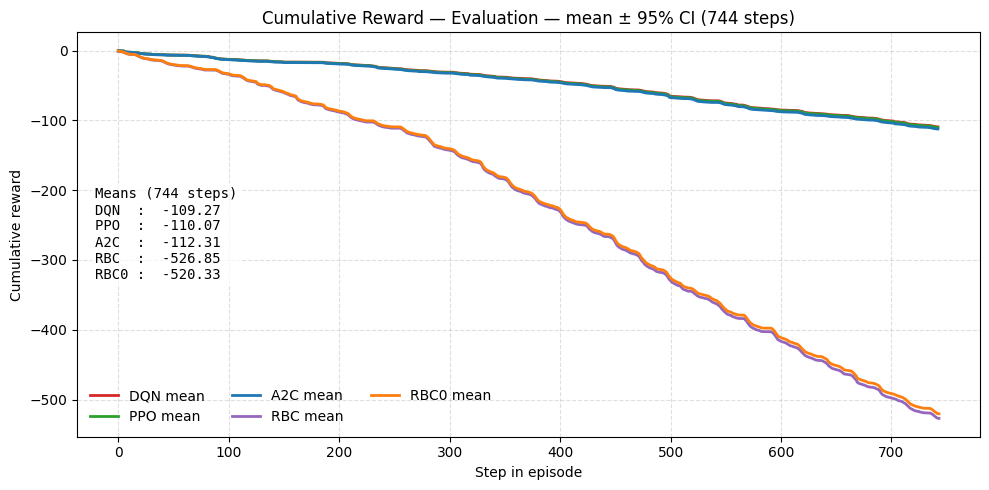


DQN  : mean=-109.27, std=0.03, n=10
PPO  : mean=-110.07, std=0.23, n=10
A2C  : mean=-112.31, std=0.77, n=10
RBC  : mean=-526.85, std=0.00, n=10
RBC0 : mean=-520.33, std=0.00, n=10


In [39]:
# ==== Cumulative Reward — Evaluation (mean ± 95% CI, 744 Steps) ====
plt.figure(figsize=(10,5))

order = ["DQN","PPO","A2C","RBC","RBC0"]
for name in order:
    if name not in models:
        continue
    x, mean, ci = mean_ci_cumcurves_pad(models[name])
    # Sicherheitshalber auf 744 Steps schneiden
    L = min(len(x), EVAL_MAX_STEPS)
    x, mean = x[:L], mean[:L]
    ci = (ci[:L] if ci is not None else None)

    c = COLOR.get(name, None)
    plt.plot(x, mean, lw=2, label=f"{name} mean", color=c)
    if ci is not None and np.any(ci):
        plt.fill_between(x, mean-ci, mean+ci, alpha=0.15, linewidth=0, color=c)

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("Cumulative Reward — Evaluation — mean ± 95% CI (744 steps)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False, ncol=3)

# ==== Means im Plot anzeigen (links mittig) ====
ax = plt.gca()

def _episode_returns(step_lists, max_steps):
    return np.array([np.sum(s[:max_steps]) for s in step_lists], float)

mean_lines = []
for name in order:
    if name not in models or not models[name]:
        continue
    rets = _episode_returns(models[name], EVAL_MAX_STEPS)
    m = rets.mean() if rets.size else float("nan")
    mean_lines.append(f"{name:<5}: {m:>8.2f}")

txt = "Means (744 steps)\n" + "\n".join(mean_lines)

ax.text(
    0.02, 0.50, txt,
    transform=ax.transAxes,
    ha="left", va="center",
    fontsize=10,
    family="monospace",
    bbox=dict(boxstyle="round", fc="white", ec="none", alpha=0.75)
)


plt.tight_layout()
plt.show()

# ---- Prints: Episoden-Returns je Modell (mean, std, n) ----
def _episode_returns(step_lists):
    # step_lists: List[np.ndarray] mit per-step rewards (bereits auf 744 gekappt)
    return np.array([np.sum(s) for s in step_lists], float)

print()  # Leerzeile
for name in order:
    if name not in models or not models[name]:
        continue
    rets = _episode_returns(models[name])
    n = rets.size
    mean_val = float(np.mean(rets)) if n else float("nan")
    std_val  = float(np.std(rets, ddof=1)) if n > 1 else 0.0
    print(f"{name:<5}: mean={mean_val:.2f}, std={std_val:.2f}, n={n}")


##### Cumulative Reward RL models

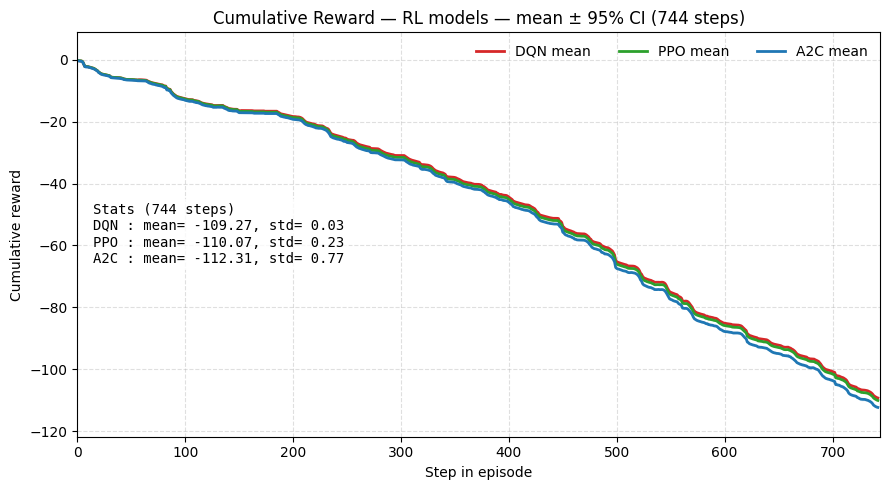

In [40]:
# ==== Cumulative Reward — RL models only (zoomed, 744 steps) + Stats-Box ====
plt.figure(figsize=(9,5))

rl_only = [n for n in ["DQN","PPO","A2C"] if n in models]
y_collect = []

for name in rl_only:
    x, mean, ci = mean_ci_cumcurves_pad(models[name])
    L = min(len(x), EVAL_MAX_STEPS)  # = 744
    x, mean = x[:L], mean[:L]
    c = COLOR.get(name)

    plt.plot(x, mean, lw=2, label=f"{name} mean", color=c)
    if ci is not None and np.any(ci):
        ci = ci[:L]
        plt.fill_between(x, mean-ci, mean+ci, alpha=0.18, linewidth=0, color=c)
        y_collect.append(mean-ci); y_collect.append(mean+ci)
    else:
        y_collect.append(mean)

# Auto-Zoom auf RL-Bereich (mit etwas Padding)
if y_collect:
    Y = np.concatenate([np.asarray(v, float) for v in y_collect])
    y_min, y_max = np.nanmin(Y), np.nanmax(Y)
    pad = max(1.0, 0.08 * (y_max - y_min))
    plt.ylim(y_min - pad, y_max + pad)

plt.xlim(0, EVAL_MAX_STEPS)
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("Cumulative Reward — RL models — mean ± 95% CI (744 steps)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False, ncol=3)

# ---- Stats-Box mit exakten Werten ----
def _episode_returns(step_lists, max_steps):
    return np.array([np.sum(np.asarray(s, float)[:max_steps]) for s in step_lists], float)

lines = []
for name in rl_only:
    rets = _episode_returns(models[name], EVAL_MAX_STEPS)
    n = rets.size
    mean_val = float(np.mean(rets)) if n else float("nan")
    std_val  = float(np.std(rets, ddof=1)) if n > 1 else 0.0
    lines.append(f"{name:<4}: mean={mean_val:>8.2f}, std={std_val:>5.2f}")

txt = "Stats (744 steps)\n" + "\n".join(lines)
ax = plt.gca()
ax.text(
    0.02, 0.50, txt,
    transform=ax.transAxes,
    ha="left", va="center",
    fontsize=10, family="monospace",
    bbox=dict(boxstyle="round", fc="white", ec="none", alpha=0.8)
)

plt.tight_layout()
plt.show()


##### Cumulative Reward RL models banded

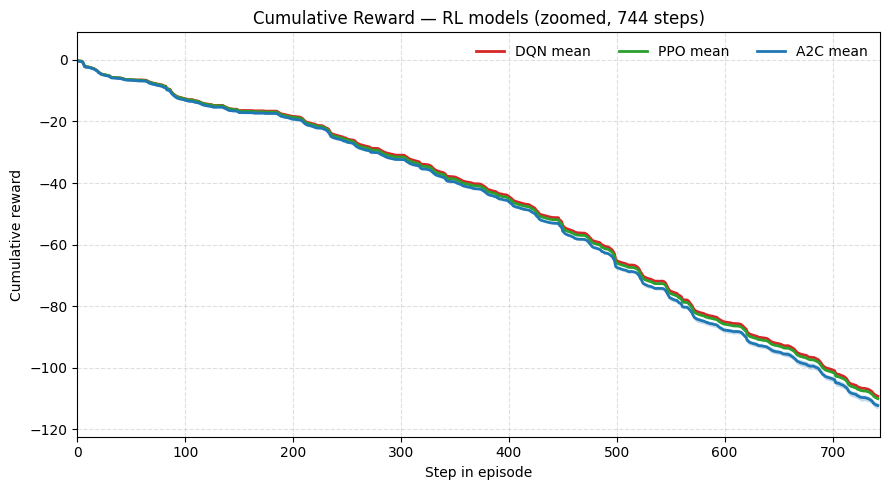

In [5]:
# ==== RL models only (zoomed, 744 steps) with visible spread band ====
plt.figure(figsize=(9,5))
rl_only = [n for n in ["DQN","PPO","A2C"] if n in models]
y_collect = []

for name in rl_only:
    x, mean, lo, hi = cumcurve_band(models[name], band="percentile")  # or "std"
    L = min(len(x), EVAL_MAX_STEPS)
    x, mean, lo, hi = x[:L], mean[:L], lo[:L], hi[:L]
    c = COLOR.get(name)

    plt.plot(x, mean, lw=2, label=f"{name} mean", color=c)
    plt.fill_between(x, lo, hi, alpha=0.25, linewidth=0, color=c, zorder=0)

    y_collect.append(lo); y_collect.append(hi)

# auto-zoom around shown bands
if y_collect:
    Y = np.concatenate([np.asarray(v, float) for v in y_collect])
    y_min, y_max = np.nanmin(Y), np.nanmax(Y)
    pad = max(0.5, 0.08 * (y_max - y_min))
    plt.ylim(y_min - pad, y_max + pad)

plt.xlim(0, EVAL_MAX_STEPS)
plt.xlabel("Step in episode"); plt.ylabel("Cumulative reward")
plt.title("Cumulative Reward — RL models (zoomed, 744 steps)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False, ncol=3)
plt.tight_layout(); plt.show()


##### Bar plot all models

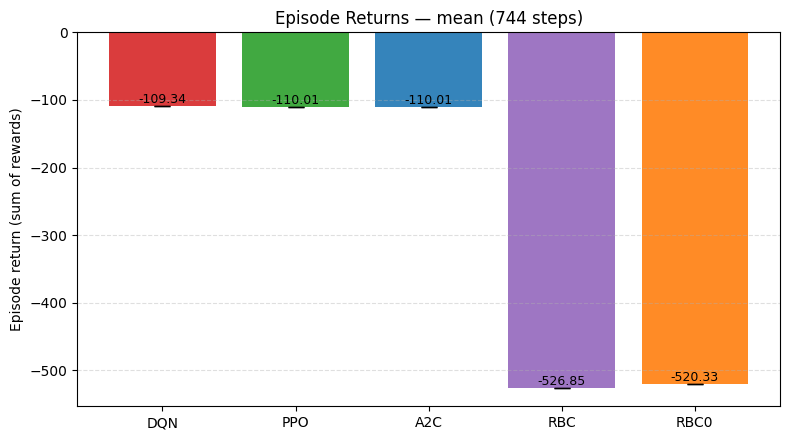

DQN  : mean=-109.34, std=0.00, n=10
PPO  : mean=-110.01, std=0.00, n=10
A2C  : mean=-110.01, std=0.00, n=10
RBC  : mean=-526.85, std=0.00, n=10
RBC0 : mean=-520.33, std=0.00, n=10


In [ ]:
# ==== Bar Plot — Episode Returns (mean ± 95% CI, 744 Steps) ====
import numpy as np
import matplotlib.pyplot as plt

def _episode_returns(step_lists, max_steps):
    # Summe über *max_steps* pro Episode
    return np.array([np.sum(np.asarray(s, float)[:max_steps]) for s in step_lists], float)

def _mean_ci95(a):
    a = np.asarray(a, float).ravel()
    m = np.mean(a)
    sd = np.std(a, ddof=1) if a.size > 1 else 0.0
    ci = 1.96 * sd / np.sqrt(max(1, a.size))
    return m, ci

order = [n for n in ["DQN","PPO","A2C","RBC","RBC0"] if n in models and models[n]]

labels, means, cis, cols, stats = [], [], [], [], []
for name in order:
    rets = _episode_returns(models[name], EVAL_MAX_STEPS)
    m, ci = _mean_ci95(rets)
    labels.append(name)
    means.append(m)
    cis.append(ci)
    cols.append(COLOR.get(name, None))
    stats.append((name, m, rets.std(ddof=1) if rets.size > 1 else 0.0, rets.size))

fig, ax = plt.subplots(figsize=(8,4.5))
x = np.arange(len(labels))
bars = ax.bar(x, means, yerr=cis, capsize=6, color=cols, alpha=0.9)

# Annotationen (Mean-Wert) über/auf den Balken
for xi, b, m in zip(x, bars, means):
    ax.text(xi, b.get_height(), f"{m:.2f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel("Episode return (sum of rewards)")
ax.set_title("Episode Returns — mean (744 steps)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Konsolen-Stats (optional)
for name, m, s, n in stats:
    print(f"{name:5s}: mean={m:.2f}, std={s:.2f}, n={n}")


##### Net_Load with vs without Battery

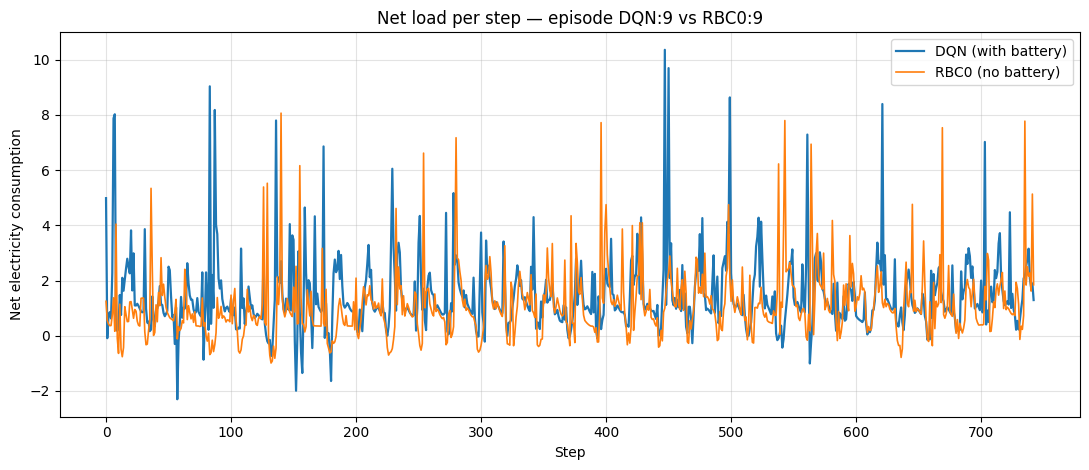

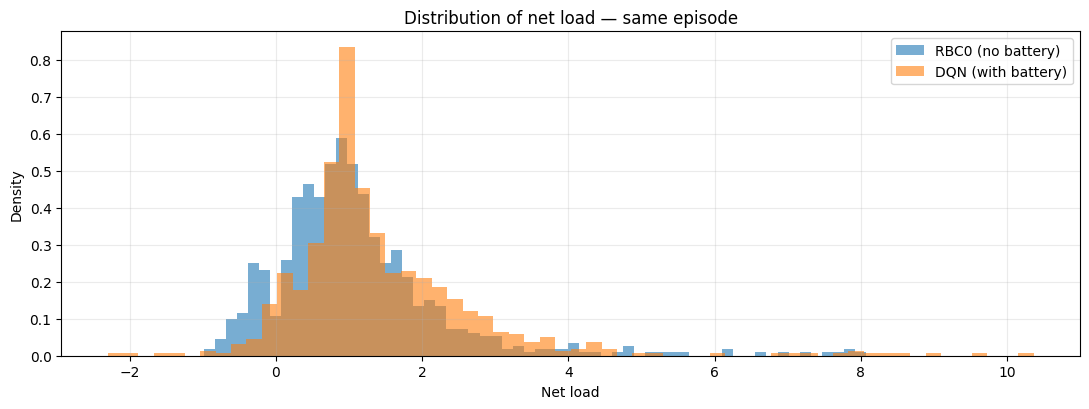

Episode lengths (aligned to 743): DQN=743, RBC0=743
Means:    DQN=1.4367, RBC0=1.1028
Medians:  DQN=1.0899, RBC0=0.9127
Min/Max DQN:  -2.3034 / 10.3631
Min/Max RBC0: -0.9904 / 8.0668


In [41]:
# === Compare net_load: DQN (with battery) vs RBC0 (no battery; CSV) ===
# Set these to your saved eval files:
EVAL_FILE_DQN  = DQN_EVAL_FILE          # pickle with eval dict
EVAL_FILE_RBC0 = RBC0_LOG_FILE          # CSV logfile

import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- loaders ----------
def _load_eval_pickle(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Eval file not found: {os.path.abspath(path)}")
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data

def _load_rbc0_csv_as_eval(path):
    """
    Load an RBC0 CSV and return a dict that mimics the eval-pickle structure for the keys we need:
      { 'ep_net_load': [np.array per episode], 'price_df': <pd.DataFrame or None> }
    Column detection is tolerant. Episodes are taken from 'episode' if present; otherwise single episode.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"RBC0 CSV not found: {os.path.abspath(path)}")
    df = pd.read_csv(path)

    # Pick net-load column (most likely candidates first)
    net_candidates = [
        "net_load",
        "net_electricity_consumption_without_storage",
        "net_electricity_consumption",
        "net_load_no_storage",
    ]
    net_col = next((c for c in net_candidates if c in df.columns), None)
    if net_col is None:
        # try a heuristic: any column containing 'net' and 'load' or 'consumption'
        for c in df.columns:
            lc = c.lower()
            if ("net" in lc) and (("load" in lc) or ("consumption" in lc)):
                net_col = c
                break
    if net_col is None:
        raise KeyError(f"No net-load column found in RBC0 CSV. Tried {net_candidates}. Columns: {list(df.columns)[:12]} ...")

    # Clean to numeric
    df[net_col] = pd.to_numeric(df[net_col], errors="coerce")

    # Optional: price_df (for building a time index)
    price_df = None
    # If the CSV already has a timestamp/price column, we can pass it along
    # (harmless if missing; plotting falls back to a simple RangeIndex)
    ts_col = next((c for c in ("timestamp", "time", "datetime", "date", "Date", "Datetime") if c in df.columns), None)
    if ts_col is not None:
        tmp = pd.DataFrame({ts_col: pd.to_datetime(df[ts_col], errors="coerce")})
        price_df = tmp  # minimal frame used only for time indexing

    # Segment by episode if available, else single chunk
    if "episode" in df.columns:
        groups = []
        for ep, g in df.groupby("episode", sort=True):
            arr = pd.to_numeric(g[net_col], errors="coerce").dropna().to_numpy(dtype=float)
            if arr.size:
                groups.append(arr)
        if not groups:
            raise ValueError("RBC0 CSV 'episode' present but no valid rows after cleaning.")
        ep_net_load = groups
    else:
        arr = pd.to_numeric(df[net_col], errors="coerce").dropna().to_numpy(dtype=float)
        if not arr.size:
            raise ValueError("RBC0 CSV has no valid net-load values.")
        ep_net_load = [arr]

    return {"ep_net_load": ep_net_load, "price_df": price_df}

# ---------- helpers ----------
def _episodes_to_series_list(res, key="ep_net_load"):
    """Return list of 1D float arrays (one per episode) for the given key from an eval-like dict."""
    if key not in res:
        return []
    seqs = res[key]
    out = []
    if isinstance(seqs, (list, tuple)):
        for s in seqs:
            arr = np.asarray(s, dtype=float).ravel()
            if arr.size:
                out.append(arr)
    else:
        arr = np.asarray(seqs, dtype=float).ravel()
        if arr.size:
            out.append(arr)
    return out

def _concat_episodes(seqs):
    if not seqs:
        return np.array([], dtype=float)
    return np.concatenate([np.asarray(s, dtype=float).ravel() for s in seqs], axis=0)

def _time_index_from_price_df_like(res, n_steps):
    """
    Try to build a DatetimeIndex from 'price_df' if it contains a timestamp-ish column.
    Else return RangeIndex.
    """
    if "price_df" in res and isinstance(res["price_df"], pd.DataFrame):
        pdf = res["price_df"]
        ts_col = next((c for c in ("timestamp", "time", "datetime", "date", "Date", "Datetime") if c in pdf.columns), None)
        if ts_col is not None:
            ts = pd.to_datetime(pdf[ts_col], errors="coerce")
            if ts.notna().any():
                ts = ts.dropna()
                if len(ts) >= n_steps:
                    return ts.iloc[:n_steps]
                return ts
    return pd.RangeIndex(n_steps, name="step")

# --- Load evals: DQN from pickle, RBC0 from CSV
res_dqn  = _load_eval_pickle(EVAL_FILE_DQN)
res_rbc0 = _load_rbc0_csv_as_eval(EVAL_FILE_RBC0)

# --- Extract per-episode net_load arrays
dqn_eps  = _episodes_to_series_list(res_dqn,  key="ep_net_load")
rbc_eps  = _episodes_to_series_list(res_rbc0, key="ep_net_load")

if not dqn_eps:
    raise KeyError("DQN eval has no 'ep_net_load'. Make sure you saved it in evaluate_with_metrics.")
if not rbc_eps:
    raise KeyError("RBC0 CSV yielded no 'ep_net_load'. Check column names and data cleaning.")

# Choose how to compare: per-episode overlay OR concatenated series
COMPARE_MODE = "per_episode"   # options: "per_episode", "concatenated"
EPISODE_IDX  = -1              # used only when COMPARE_MODE == "per_episode"; -1 = last

if COMPARE_MODE == "per_episode":
    # pick matching episode index within bounds
    i_dqn  = (len(dqn_eps) - 1) if EPISODE_IDX == -1 else int(np.clip(EPISODE_IDX, 0, len(dqn_eps)-1))
    i_rbc0 = (len(rbc_eps) - 1) if EPISODE_IDX == -1 else int(np.clip(EPISODE_IDX, 0, len(rbc_eps)-1))

    y_dqn  = dqn_eps[i_dqn]
    y_rbc0 = rbc_eps[i_rbc0]

    # align lengths if they differ
    L = min(len(y_dqn), len(y_rbc0))
    y_dqn, y_rbc0 = y_dqn[:L], y_rbc0[:L]

    # time index from DQN (preferred) or RBC0; fallback RangeIndex
    t = _time_index_from_price_df_like(res_dqn, L)
    if len(t) != L:
        t = _time_index_from_price_df_like(res_rbc0, L)
    if len(t) != L:
        t = pd.RangeIndex(L, name="step")

    # Plot time series
    plt.figure(figsize=(11, 4.8))
    plt.plot(t, y_dqn,  lw=1.6, label="DQN (with battery)")
    plt.plot(t, y_rbc0, lw=1.2, label="RBC0 (no battery)")
    plt.title(f"Net load per step — episode DQN:{i_dqn} vs RBC0:{i_rbc0}")
    plt.xlabel("Time" if isinstance(t, pd.DatetimeIndex) else "Step")
    plt.ylabel("Net electricity consumption")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Distribution comparison for the same episode
    plt.figure(figsize=(11, 4.2))
    bins = 60
    plt.hist(y_rbc0, bins=bins, alpha=0.6, density=True, label="RBC0 (no battery)")
    plt.hist(y_dqn,  bins=bins, alpha=0.6, density=True, label="DQN (with battery)")
    plt.title("Distribution of net load — same episode")
    plt.xlabel("Net load")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Episode lengths (aligned to {L}): DQN={len(y_dqn)}, RBC0={len(y_rbc0)}")
    print(f"Means:    DQN={np.mean(y_dqn):.4f}, RBC0={np.mean(y_rbc0):.4f}")
    print(f"Medians:  DQN={np.median(y_dqn):.4f}, RBC0={np.median(y_rbc0):.4f}")
    print(f"Min/Max DQN:  {np.min(y_dqn):.4f} / {np.max(y_dqn):.4f}")
    print(f"Min/Max RBC0: {np.min(y_rbc0):.4f} / {np.max(y_rbc0):.4f}")

elif COMPARE_MODE == "concatenated":
    # stitch all episodes and compare across the whole eval horizon
    y_dqn_all  = _concat_episodes(dqn_eps)
    y_rbc_all  = _concat_episodes(rbc_eps)
    L = min(len(y_dqn_all), len(y_rbc_all))
    y_dqn_all, y_rbc_all = y_dqn_all[:L], y_rbc_all[:L]

    t = _time_index_from_price_df_like(res_dqn, L)
    if len(t) != L:
        t = _time_index_from_price_df_like(res_rbc0, L)
    if len(t) != L:
        t = pd.RangeIndex(L, name="step")

    plt.figure(figsize=(12, 5))
    plt.plot(t, y_dqn_all, lw=1.1, label="DQN (with battery)")
    plt.plot(t, y_rbc_all, lw=0.9, label="RBC0 (no battery)")
    plt.title("Net load per step — all eval episodes concatenated")
    plt.xlabel("Time" if isinstance(t, pd.DatetimeIndex) else "Global step")
    plt.ylabel("Net electricity consumption")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Total steps (aligned to {L}): DQN={len(y_dqn_all)}, RBC0={len(y_rbc_all)}")
    print(f"Means:    DQN={np.mean(y_dqn_all):.4f}, RBC0={np.mean(y_rbc_all):.4f}")
    print(f"Medians:  DQN={np.median(y_dqn_all):.4f}, RBC0={np.median(y_rbc_all):.4f}")
else:
    raise ValueError("Unknown COMPARE_MODE. Use 'per_episode' or 'concatenated'.")


##### Netload battery vs no battery vs price

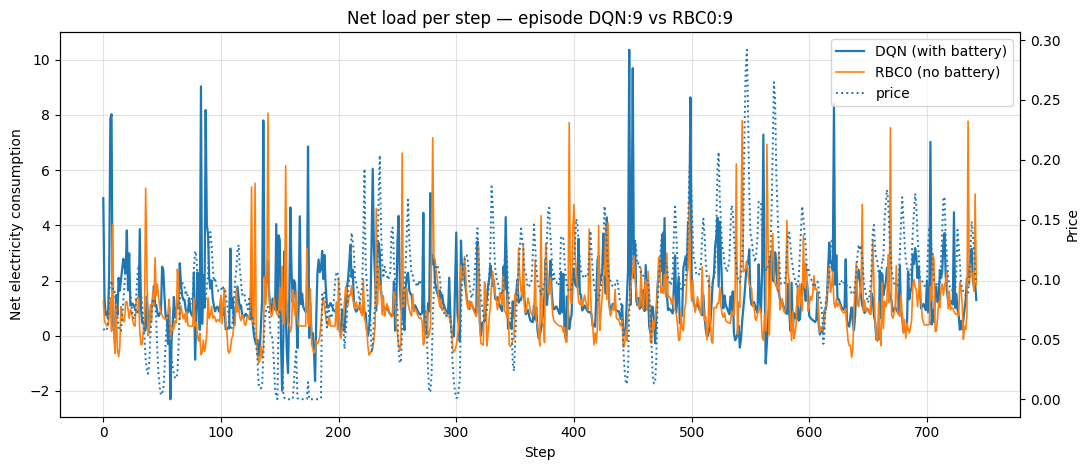

In [28]:
# ===== Add price overlay (per_episode) =====
def _extract_episode_price(res_eval_like, ep_idx, L_hint=None):
    """Gibt np.ndarray Preisfolge für Episode ep_idx zurück; kürzt/streckt auf L_hint falls angegeben."""
    # 1) bevorzugt: per-episode Preis
    if "ep_price" in res_eval_like and isinstance(res_eval_like["ep_price"], (list, tuple)):
        if 0 <= ep_idx < len(res_eval_like["ep_price"]):
            p = np.asarray(res_eval_like["ep_price"][ep_idx], float).ravel()
            if L_hint is not None:
                p = p[:L_hint]
            return p

    # 2) fallback: price_df mit Spaltenerkennung
    if "price_df" in res_eval_like and isinstance(res_eval_like["price_df"], pd.DataFrame):
        pdf = res_eval_like["price_df"]
        cand = [c for c in ["electricity_pricing","price","tariff","p","Price","pricing"] if c in pdf.columns]
        if cand:
            p = pd.to_numeric(pdf[cand[0]], errors="coerce").to_numpy(dtype=float)
            if L_hint is not None:
                p = p[:L_hint]
            return p

    # 3) nichts gefunden
    return None

if COMPARE_MODE == "per_episode":
    # --- (dein bestehender Code oben bleibt gleich, bis zum Plot) ---
    i_dqn  = (len(dqn_eps) - 1) if EPISODE_IDX == -1 else int(np.clip(EPISODE_IDX, 0, len(dqn_eps)-1))
    i_rbc0 = (len(rbc_eps) - 1) if EPISODE_IDX == -1 else int(np.clip(EPISODE_IDX, 0, len(rbc_eps)-1))

    y_dqn  = dqn_eps[i_dqn]
    y_rbc0 = rbc_eps[i_rbc0]
    L = min(len(y_dqn), len(y_rbc0))
    y_dqn, y_rbc0 = y_dqn[:L], y_rbc0[:L]

    # Zeitachse wie gehabt
    t = _time_index_from_price_df_like(res_dqn, L)
    if len(t) != L:
        t = _time_index_from_price_df_like(res_rbc0, L)
    if len(t) != L:
        t = pd.RangeIndex(L, name="step")

    # --- Preise holen (DQN bevorzugt) ---
    price = _extract_episode_price(res_dqn, i_dqn, L_hint=L)
    if price is None:
        price = _extract_episode_price(res_rbc0, i_rbc0, L_hint=L)

    # --- Plot mit zweiter y-Achse ---
    fig, ax1 = plt.subplots(figsize=(11, 4.8))
    l1, = ax1.plot(t, y_dqn,  lw=1.6, label="DQN (with battery)")
    l2, = ax1.plot(t, y_rbc0, lw=1.2, label="RBC0 (no battery)")

    ax1.set_title(f"Net load per step — episode DQN:{i_dqn} vs RBC0:{i_rbc0}")
    ax1.set_xlabel("Time" if isinstance(t, pd.DatetimeIndex) else "Step")
    ax1.set_ylabel("Net electricity consumption")
    ax1.grid(True, alpha=0.35)

    if price is not None and price.size:
        ax2 = ax1.twinx()
        l3, = ax2.plot(t, price, linestyle=":", lw=1.4, label="price")
        ax2.set_ylabel("Price")
        # Gemeinsame Legende
        lines = [l1, l2, l3]
    else:
        lines = [l1, l2]

    labs = [ln.get_label() for ln in lines]
    ax1.legend(lines, labs, loc="upper right")
    plt.tight_layout()
    plt.show()


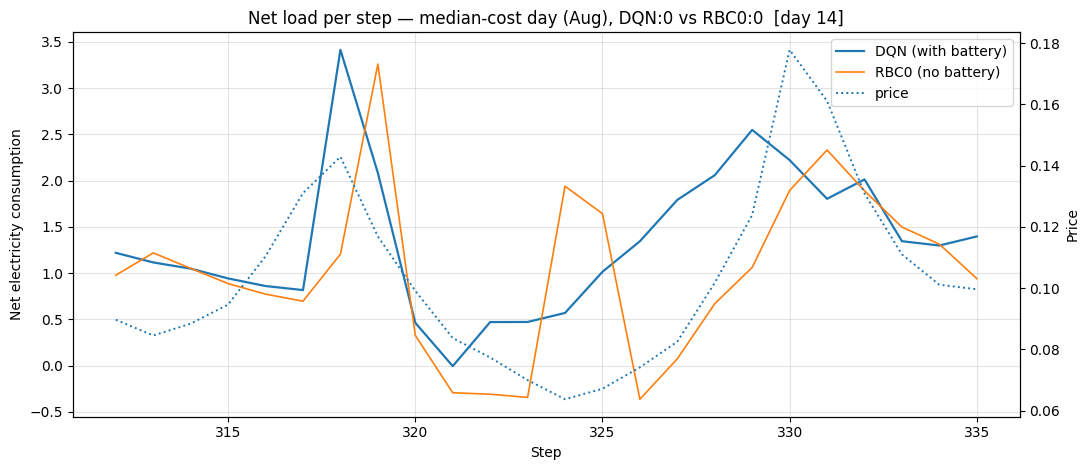

Median-cost day index (0-based): 13
DQN daily cost (sum price*net): 3.680


In [19]:
# ---- Plot ONE selected day: the median daily-cost day (using DQN's cost = price * net_load) ----
# Assumes arrays: y_dqn, y_rbc0, price, and index t (DatetimeIndex or RangeIndex)
# Typical length L = 744 (31 days * 24 steps)

L = min(len(y_dqn), len(y_rbc0), len(price))
y_dqn, y_rbc0, price = y_dqn[:L], y_rbc0[:L], price[:L]
t = t[:L]

# Infer steps-per-day robustly (prefer 31 days in August)
DAYS = 31
if L % DAYS == 0:
    STEPS_PER_DAY = L // DAYS
else:
    # fallback: try 24, else just treat as 24
    STEPS_PER_DAY = 24

# Compute daily costs for DQN (battery case)
cost_series = price * y_dqn
day_costs = np.array([
    cost_series[d*STEPS_PER_DAY:(d+1)*STEPS_PER_DAY].sum()
    for d in range(L // STEPS_PER_DAY)
], dtype=float)

# Pick median-cost day index
d_med = int(np.argsort(day_costs)[len(day_costs)//2])

# Slice that day
sl = slice(d_med*STEPS_PER_DAY, (d_med+1)*STEPS_PER_DAY)
y_dqn_day  = y_dqn[sl]
y_rbc0_day = y_rbc0[sl]
price_day  = price[sl]
t_day      = t[sl]

# Plot
fig, ax1 = plt.subplots(figsize=(11, 4.8))
l1, = ax1.plot(t_day, y_dqn_day,  lw=1.6, label="DQN (with battery)")
l2, = ax1.plot(t_day, y_rbc0_day, lw=1.2, label="RBC0 (no battery)")

ax1.set_title(f"Net load per step — median-cost day (Aug), DQN:{i_dqn} vs RBC0:{i_rbc0}  [day {d_med+1}]")
ax1.set_xlabel("Time" if isinstance(t_day, pd.DatetimeIndex) else "Step")
ax1.set_ylabel("Net electricity consumption")
ax1.grid(True, alpha=0.35)

ax2 = ax1.twinx()
l3, = ax2.plot(t_day, price_day, linestyle=":", lw=1.4, label="price")
ax2.set_ylabel("Price")

# unified legend
lines = [l1, l2, l3]
ax1.legend(lines, [ln.get_label() for ln in lines], loc="upper right")

plt.tight_layout()
plt.show()

print(f"Median-cost day index (0-based): {d_med}")
print(f"DQN daily cost (sum price*net): {day_costs[d_med]:.3f}")


##### Netload vs price 

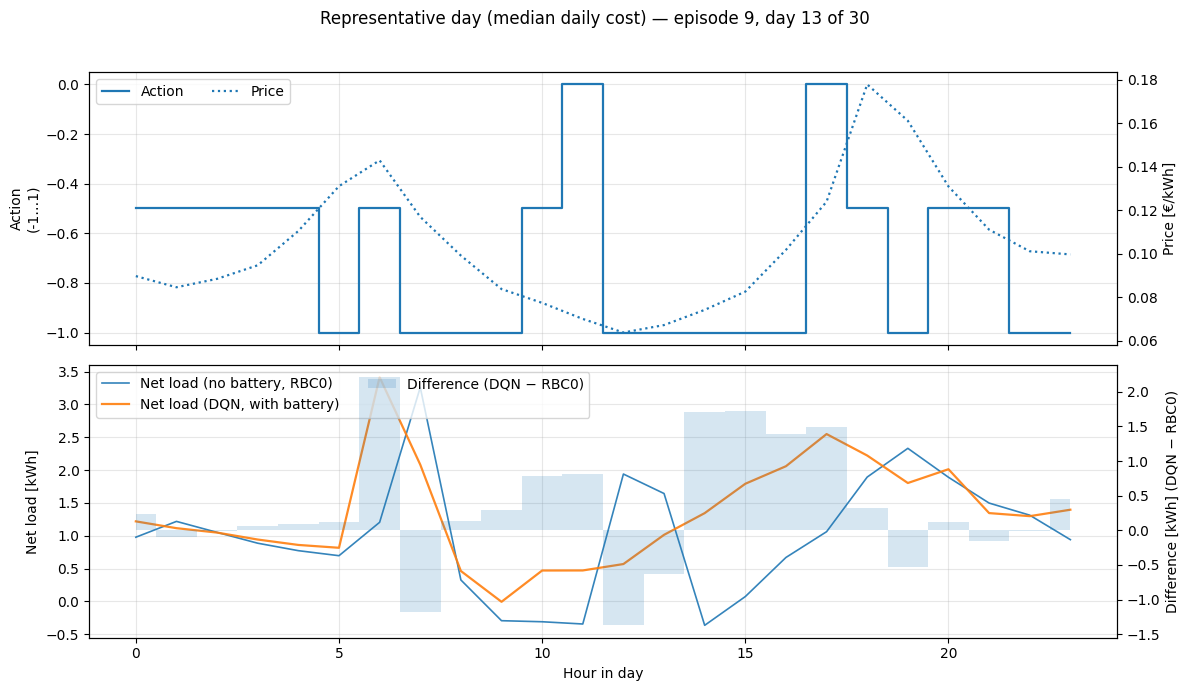

In [43]:
# ================= Representative Day (median-cost day) panels =================
# Requirements in your eval pickle (per episode lists):
#   res_dqn:  'ep_net_load' (list[np.ndarray]), 
#             optionally 'ep_price', 'ep_action', 'ep_soc', 'price_df' (timestamps)
#   res_rbc0: 'ep_net_load', optionally 'ep_price' or 'price_df'
# Uses the last evaluation episode by default.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']
NAME_TO_FRAC = {
    'discharge_full': -1.0,
    'discharge_half': -0.5,
    'idle': 0.0,
    'charge_half': 0.5,
    'charge_full': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)
# NEU: Dict-Variante für das Mapping diskreter IDs -> [-1,1]
INT_TO_FRAC_DICT = {i: float(v) for i, v in enumerate(INT_TO_FRAC)}

# --- helpers (reuse your earlier loaders if already defined) ------------------
def _episodes_to_series_list(res, key):
    if key not in res:
        return []
    seqs = res[key]
    if isinstance(seqs, (list, tuple)):
        return [np.asarray(s, float).ravel() for s in seqs if np.asarray(s).size]
    arr = np.asarray(seqs, float).ravel()
    return [arr] if arr.size else []

def _extract_ep_array(res, key, ep_idx, L=None):
    """Fetch per-episode array if present, else None. Optionally trim to length L."""
    if key in res and isinstance(res[key], (list, tuple)) and 0 <= ep_idx < len(res[key]):
        a = np.asarray(res[key][ep_idx], float).ravel()
        return a[:L] if (L is not None) else a
    return None

def _infer_steps_per_day(res_eval_like, default=24):
    # Try timestamps in price_df to infer cadence
    try:
        pdf = res_eval_like.get("price_df", None)
        if isinstance(pdf, pd.DataFrame):
            ts_col = next((c for c in ("timestamp","time","datetime","date","Date","Datetime") if c in pdf.columns), None)
            if ts_col is not None:
                ts = pd.to_datetime(pdf[ts_col], errors="coerce").dropna()
                if len(ts) >= 3:
                    # median delta in hours
                    hrs = pd.Series(ts.diff().dt.total_seconds()).median() / 3600.0
                    if hrs and np.isfinite(hrs) and hrs > 0:
                        return int(round(24.0 / hrs))
    except Exception:
        pass
    return default

def _daily_cost(price, netload, steps_per_day):
    L = min(len(price), len(netload))
    price, netload = price[:L], netload[:L]
    # reshape to days
    D = L // steps_per_day
    price = price[: D*steps_per_day].reshape(D, steps_per_day)
    net   = netload[: D*steps_per_day].reshape(D, steps_per_day)
    daily_cost = (price * net).sum(axis=1)   # EUR per day (sign as in your data)
    return daily_cost, D, steps_per_day

# -------------------- choose episode and build arrays -------------------------
EPISODE_IDX = -1  # last episode

# Per-episode DQN series
dqn_net = _episodes_to_series_list(res_dqn, "ep_net_load")
if not dqn_net:
    raise KeyError("DQN eval pickle missing 'ep_net_load'.")

ep_idx = (len(dqn_net) - 1) if EPISODE_IDX == -1 else int(np.clip(EPISODE_IDX, 0, len(dqn_net)-1))
y_dqn = np.asarray(dqn_net[ep_idx], float)

# Matching RBC0 episode
rbc_net = _episodes_to_series_list(res_rbc0, "ep_net_load")
if not rbc_net:
    raise KeyError("RBC0 CSV missing 'ep_net_load'.")
y_rbc0 = np.asarray(rbc_net[min(ep_idx, len(rbc_net)-1)], float)

# Align lengths
L = min(len(y_dqn), len(y_rbc0))
y_dqn = y_dqn[:L]
y_rbc0 = y_rbc0[:L]

# Price: prefer DQN per-episode, else RBC0, else None
p = _extract_ep_array(res_dqn,  "ep_price",  ep_idx, L=L)
if p is None:
    p = _extract_ep_array(res_rbc0, "ep_price", min(ep_idx, len(rbc_net)-1), L=L)
if p is None:
    raise KeyError("No per-episode price found. Ensure 'ep_price' exists in at least one result.")

# ----- robust action extractor: returns actions in [-1, 1] if available -----
def _extract_episode_action_norm(res_eval_like, ep_idx, L_hint=None, int_to_frac=None):
    # 1) Continuous candidates
    cont_keys = ("ep_action_fracs", "ep_action", "ep_actions", "actions_cont", "action_cont")
    for key in cont_keys:
        if key in res_eval_like and isinstance(res_eval_like[key], (list, tuple)) and 0 <= ep_idx < len(res_eval_like[key]):
            a = np.asarray(res_eval_like[key][ep_idx], float).ravel()
            if a.size:
                amin, amax = np.nanmin(a), np.nanmax(a)
                if 0.0 <= amin and amax <= 1.0:
                    a = 2.0 * a - 1.0  # 0..1 -> -1..1
                return a[:L_hint] if L_hint is not None else a

    # 2) Discrete IDs -> map
    disc_keys = ("actions_disc_list", "ep_action_ids", "ep_action_idx", "ep_actions_disc")
    for key in disc_keys:
        if key in res_eval_like and isinstance(res_eval_like[key], (list, tuple)) and 0 <= ep_idx < len(res_eval_like[key]):
            idx = np.asarray(res_eval_like[key][ep_idx]).astype(int).ravel()
            if idx.size:
                mapping = int_to_frac or {0:-1.0, 1:-0.5, 2:0.0, 3:0.5, 4:1.0}
                # handle dict or numpy array
                if hasattr(mapping, "get"):
                    lookup = np.vectorize(lambda i: float(mapping.get(int(i), np.nan)))
                    a = lookup(idx)
                else:
                    arr = np.asarray(mapping, float)
                    a = arr[np.clip(idx, 0, len(arr)-1)]
                return a[:L_hint] if L_hint is not None else a
    return None

a = _extract_episode_action_norm(
        res_dqn, ep_idx, L_hint=L,
        int_to_frac=INT_TO_FRAC_DICT
     )

soc = _extract_ep_array(res_dqn, "ep_soc", ep_idx, L=L)

# Steps per day (try from timestamps; fallback 24)
SPD = _infer_steps_per_day(res_dqn, default=24)

# -------------------- select representative (median-cost) day -----------------
daily_cost, D, spd = _daily_cost(p, y_dqn, SPD)
if D == 0:
    raise ValueError("Episode shorter than one day after alignment—cannot build representative day.")
median_day_idx = int(np.argsort(daily_cost)[D // 2])

# Slice day window
s0 = median_day_idx * spd
s1 = s0 + spd
t = np.arange(spd)  # local time index (0..spd-1)

p_day     = p[s0:s1]
y_dqn_day = y_dqn[s0:s1]
y_rbc_day = y_rbc0[s0:s1]
a_day     = a[s0:s1]   if a is not None   else None
soc_day = soc[s0:s1] if soc is not None else None
diff_day  = y_dqn_day - y_rbc_day

# ------------------------------ plotting -------------------------------------
nrows = 3 if soc_day is not None else 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(12, 7 if nrows==2 else 9), sharex=True)
axes = np.atleast_1d(axes)

# Panel A: Action (left) + Price (right)
axA = axes[0]
if a_day is not None:
    axA.step(t, a_day, where="mid", linewidth=1.6, label="Action", zorder=3)
    axA.set_ylabel("Action\n(-1…1)")
else:
    axA.set_ylabel("Action")
axA.grid(True, alpha=0.3)

axA2 = axA.twinx()
axA2.plot(t, p_day, linestyle=":", linewidth=1.6, label="Price", zorder=2)
axA2.set_ylabel("Price [€/kWh]")

# Joint legend for panel A
linesA, labelsA = [], []
for ax in (axA, axA2):
    h, l = ax.get_legend_handles_labels()
    linesA += h; labelsA += l
if linesA:
    axA.legend(linesA, labelsA, loc="upper left", ncol=2, frameon=True)

# Panel B: Net load with/without + difference (secondary axis, faint)
axB = axes[1]
axB.plot(t, y_rbc_day, linewidth=1.2, label="Net load (no battery, RBC0)", alpha=0.9)
axB.plot(t, y_dqn_day, linewidth=1.6, label="Net load (DQN, with battery)", alpha=0.9)
axB.set_ylabel("Net load [kWh]")
axB.grid(True, alpha=0.3)

axB2 = axB.twinx()
axB2.fill_between(t, 0, diff_day, alpha=0.18, step="mid", label="Difference (DQN − RBC0)")
axB2.set_ylabel("Difference [kWh] (DQN − RBC0)")

linesB, labelsB = [], []
for ax in (axB, axB2):
    h, l = ax.get_legend_handles_labels()
    linesB += h; labelsB += l
axB.legend(linesB, labelsB, loc="upper left", ncol=2, frameon=True)

# Optional Panel C: SoC
if soc_day is not None:
    axC = axes[2]
    axC.plot(t, soc_day, linewidth=1.6, label="SoC")
    axC.set_ylim(0, 1)  # SoC [0,1]
    axC.set_ylabel("SoC [0–1]")
    axC.set_xlabel("Hour in day" if SPD == 24 else "Step in day")
    axC.grid(True, alpha=0.3)
    # optional: sinnvolle SoC-Grenzen einzeichnen
    for thr, ls in [(0.2, "--"), (0.8, "--")]:
        axC.axhline(thr, color="grey", linestyle=ls, linewidth=1, alpha=0.5)
    axC.legend(loc="upper left")
else:
    axes[-1].set_xlabel("Hour in day" if SPD == 24 else "Step in day")

fig.suptitle(f"Representative day (median daily cost) — episode {ep_idx}, day {median_day_idx} of {D}")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


##### View action percentage based on price 

In [34]:
import numpy as np
import pandas as pd

# flatten all eval episodes for DQN
actions = np.concatenate([np.asarray(ep, float).ravel() for ep in res_dqn["ep_action_fracs"]])
prices  = np.concatenate([np.asarray(ep, float).ravel() for ep in res_dqn["ep_price"]])
soc     = np.concatenate([np.asarray(ep, float).ravel() for ep in res_dqn.get("ep_soc", [np.full_like(actions, np.nan)])])

# optional SoC-Filter (mittlerer Bereich)
mask = (~np.isnan(actions)) & (~np.isnan(prices))
#mask &= (soc >= 0.3) & (soc <= 0.8)

a = actions[mask]
p = prices[mask]

# Quartilsanalyse
q1, q3 = np.quantile(p, [0.25, 0.75])
lowP   = a[p <= q1]
highP  = a[p >= q3]

share_charge_lowP    = np.mean(lowP >  0.25)    # Ladeanteil im günstigsten Quartil
share_discharge_high = np.mean(highP < -0.25)   # Entladeanteil im teuersten Quartil

# Rangkorrelation
from scipy.stats import spearmanr
rho, pval = spearmanr(a, -p)  # erwartetes Vorzeichen: positiv (mehr Laden bei niedrigen Preisen)

print(f"Ladeanteil (niedrigstes Preisquartil): {share_charge_lowP:.2%}")
print(f"Entladeanteil (höchstes Preisquartil): {share_discharge_high:.2%}")
print(f"Spearman rho(a, -price) = {rho:.3f} (p={pval:.1e})")


Ladeanteil (niedrigstes Preisquartil): 17.20%
Entladeanteil (höchstes Preisquartil): 88.17%
Spearman rho(a, -price) = 0.107 (p=2.8e-20)


##### SoC vs action vs price

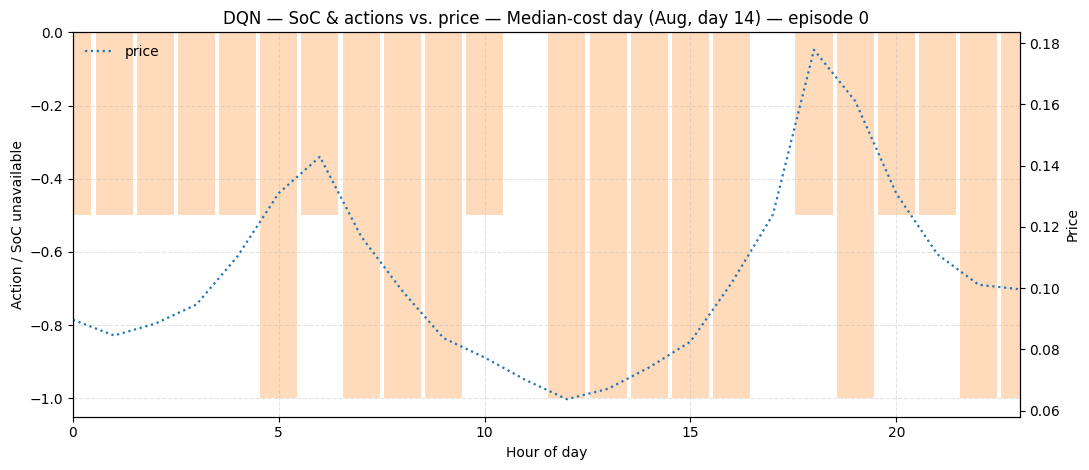

Hinweis: Im Eval-Pickle wurde kein SoC gespeichert. Plot zeigt Actions vs. Price ohne SoC.


In [24]:
# ==== DQN: SoC vs Actions vs Price — median-cost day (from eval pickle) ====
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inputs aus deinem Notebook:
# - DQN_EVAL_FILE  -> Pfad zum Pickle mit Keys wie 'ep_price', 'ep_net_load', 'ep_action_fracs', ... (optional 'ep_soc')
# - MONTH_SLICES   -> {'train':(...), 'test':(...)}  ; test = August
# - EVAL_MAX_STEPS -> 744
# - (optional) INT_TO_FRAC wird NICHT benötigt, da wir 'ep_action_fracs' lesen

EPISODE_IDX = 0  # welche Eval-Episode zeigen (0..n-1)

def _load_eval_pickle(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Eval file not found: {os.path.abspath(path)}")
    with open(path, "rb") as f:
        return pickle.load(f)

def _get_list(d, key_aliases):
    """Hole Liste[np.ndarray] unter einem der Alias-Keys; sonst []."""
    for k in key_aliases:
        if k in d:
            v = d[k]
            # normalize to list of arrays
            if isinstance(v, (list, tuple)):
                return [np.asarray(x, float).ravel() for x in v]
            else:
                return [np.asarray(v, float).ravel()]
    return []

# Laden
ev = _load_eval_pickle(DQN_EVAL_FILE)

# Reihen holen
prices = _get_list(ev, ["ep_price", "prices_per_episode", "price_list"])
nets   = _get_list(ev, ["ep_net_load", "net_load_per_episode", "net_load_list"])
acts   = _get_list(ev, ["ep_action_fracs", "action_fracs_per_episode", "actions_frac_list"])

# SoC ist optional; versuche mehrere Namen
socs   = _get_list(ev, ["ep_soc", "ep_socs", "soc_list", "ep_soc_list"])

# Minimal-Checks
assert len(prices) > 0 and len(nets) > 0 and len(acts) > 0, \
    f"Eval-Pickle muss 'ep_price', 'ep_net_load' und 'ep_action_fracs' enthalten. Keys: {list(ev.keys())[:15]} ..."

# Episode wählen & auf August-Länge kappen
START, END = MONTH_SLICES["test"]
L_AUG = END - START + 1  # = 744

def _pick(ep_list, idx, L):
    idx = (len(ep_list) - 1) if idx == -1 else int(np.clip(idx, 0, len(ep_list)-1))
    arr = ep_list[idx]
    return arr[:L], idx

price, i_used = _pick(prices, EPISODE_IDX, L_AUG)
net,   _      = _pick(nets,    EPISODE_IDX, L_AUG)
act,   _      = _pick(acts,    EPISODE_IDX, L_AUG)
soc = None
if len(socs):
    soc, _ = _pick(socs, EPISODE_IDX, L_AUG)
    if soc.size == 0:
        soc = None

# Tages-Auflösung (angenommen 24/h)
DAYS = 31
assert L_AUG % DAYS == 0, "EVAL_MAX_STEPS teilt sich nicht in ganze August-Tage."
STEPS_PER_DAY = L_AUG // DAYS

# Median-Kosten-Tag bestimmen (Kosten = price * net_load MIT Batterie)
cost_series = price * net
day_costs = np.array([cost_series[d*STEPS_PER_DAY:(d+1)*STEPS_PER_DAY].sum() for d in range(DAYS)], float)
d_med = int(np.argsort(day_costs)[DAYS//2])
sl = slice(d_med*STEPS_PER_DAY, (d_med+1)*STEPS_PER_DAY)

# Tagesdaten
x = np.arange(STEPS_PER_DAY)
price_day = price[sl]
act_day   = act[sl]
soc_day   = (soc[sl] if soc is not None and soc.size >= sl.stop else None)

# Plot
fig, ax1 = plt.subplots(figsize=(11, 4.8))

# SoC (falls vorhanden)
if soc_day is not None:
    l_soc, = ax1.step(x, soc_day, where="mid", lw=2.2, label="SoC")
    ax1.set_ylabel("State of Charge")
    ax1.set_ylim(0, 1)
else:
    l_soc = None
    ax1.set_ylabel("Action / SoC unavailable")

ax1.set_xlabel("Hour of day")
ax1.set_xlim(0, STEPS_PER_DAY-1)
ax1.grid(True, linestyle="--", alpha=0.35)

# Actions als Balken: Laden>0 oben, Entladen<0 unten
ax1.bar(x, np.clip(act_day, 0, None),  width=0.9, align='center', alpha=0.28, label="charge")
ax1.bar(x, np.clip(act_day, None, 0),  width=0.9, align='center', alpha=0.28, label="discharge")

# Price (rechte Achse)
ax2 = ax1.twinx()
l_price, = ax2.plot(x, price_day, linestyle=":", lw=1.6, label="price")
ax2.set_ylabel("Price")

# Legende
lines = [ln for ln in [l_soc, l_price] if ln is not None]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="upper left", frameon=False)

plt.title(f"DQN — SoC & actions vs. price — Median-cost day (Aug, day {d_med+1}) — episode {i_used}")
plt.tight_layout(); plt.show()

if soc is None:
    print("Hinweis: Im Eval-Pickle wurde kein SoC gespeichert. Plot zeigt Actions vs. Price ohne SoC.")

#### Feature Removal (In Progress)

##### DQN no price

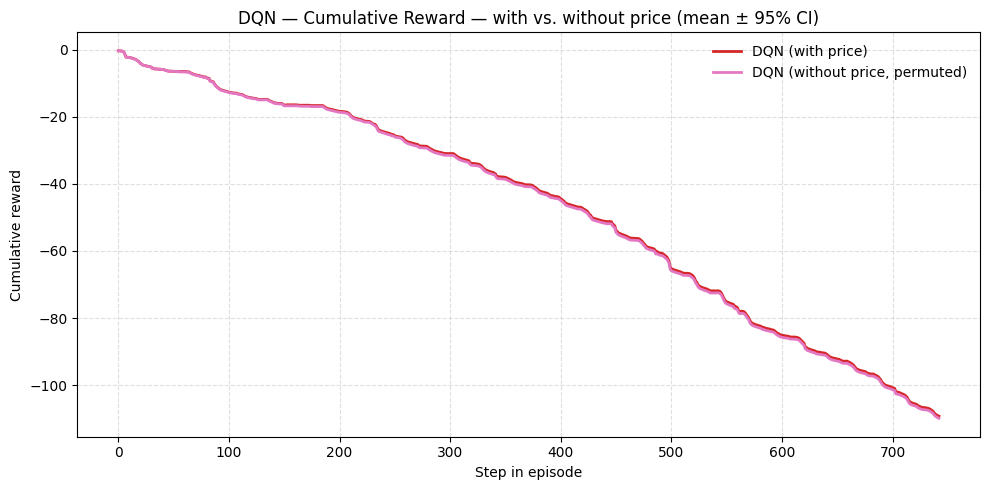

/scratch/slurm_tmpdir/job_1560401/ipykernel_2486815/2343696926.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


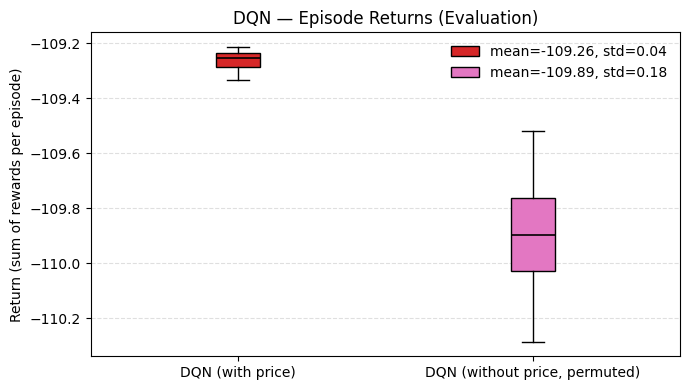

DQN (with price)              : mean=-109.262, std=0.039, n=10
DQN (without price, permuted) : mean=-109.893, std=0.183, n=200
ΔReturn per seed: mean=-0.632, std=0.184, N=20


In [14]:
# ----- DQN: with price (baseline) vs. without price (permutation across N seeds) -----

# Pfad zum neuen Paket (Baseline + N Seeds Masking)
# Beispielname – passe an, falls du einen anderen Dateinamen gewählt hast:
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/dqn'
EVAL_FILE_WITHOUT_PRICE = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_price.pkl") 
EVAL_FILE_WITHOUT_SOLAR = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_solar.pkl") 
EVAL_FILE_WITHOUT_NET_LOAD = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_net_load.pkl") 

MASK_PKL = EVAL_FILE_WITHOUT_PRICE

COLOR_BASE   = "C3"  # wie gehabt
COLOR_NOPRC  = "C6"  # neue Farbe für "ohne price"

# --- Loader für das neue Paket ---
with open(MASK_PKL, "rb") as f:
    pkg = pickle.load(f)

# Baseline (ohne Masking) aus dem Paket:
res_base_pkg = pkg["orig"]                       # dict mit 'ep_rewards_list' etc.
eps_base_pkg  = [np.asarray(e, float) for e in res_base_pkg["ep_rewards_list"]]

# Masked runs: Liste von Seeds, je Seed ein dict {"eval": res_mask, ...}
masked_runs = pkg["masked"]
eps_mask_all = []  # wir flatten alle Episoden über alle Seeds
for run in masked_runs:
    res_mask = run["eval"]
    eps_mask_all.extend([np.asarray(e, float) for e in res_mask["ep_rewards_list"]])

# --- (Optional) Falls du zum Vergleich die alte DQN-Baseline-Datei nutzen willst:
# DQN_EVAL_FILE_BASE   = DQN_EVAL_FILE
# eps_base_file  = all_episode_step_rewards_from_pkl(DQN_EVAL_FILE_BASE)
# -> Hier nutzen wir die Baseline aus dem Masking-Paket (eps_base_pkg), damit Fenster/Config exakt matchen.

# --- mean ± 95% CI der kumulativen Rewards (auf min-Länge getrimmt) ---
mc_base  = mean_ci_cumcurves(eps_base_pkg)
mc_noprc = mean_ci_cumcurves(eps_mask_all)
if mc_base is None or mc_noprc is None:
    raise ValueError("Keine Episoden gefunden in Baseline oder Masking-Paket.")

mean_base,  ci_base  = mc_base
mean_noprc, ci_noprc = mc_noprc

x_base  = np.arange(len(mean_base))
x_noprc = np.arange(len(mean_noprc))

# ---- Plot 1: cumulative reward (mean ± 95% CI) ----
plt.figure(figsize=(10,5))
plt.plot(x_base,  mean_base,  lw=2, color=COLOR_BASE,  label="DQN (with price)")
if ci_base is not None and np.any(ci_base):
    plt.fill_between(x_base, mean_base-ci_base, mean_base+ci_base, alpha=0.15, linewidth=0, color=COLOR_BASE)

plt.plot(x_noprc, mean_noprc, lw=2, color=COLOR_NOPRC, label="DQN (without price, permuted)")
if ci_noprc is not None and np.any(ci_noprc):
    plt.fill_between(x_noprc, mean_noprc-ci_noprc, mean_noprc+ci_noprc, alpha=0.15, linewidth=0, color=COLOR_NOPRC)

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("DQN — Cumulative Reward — with vs. without price (mean ± 95% CI)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---- Plot 2: Episode-Returns (Boxplot) ----
fig, ax = plt.subplots(figsize=(7,4))
data   = [ret_base, ret_noprc]
labels = ["DQN (with price)", "DQN (without price, permuted)"]
colors = [COLOR_BASE, COLOR_NOPRC]

bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(c)
for med in bp['medians']:
    med.set_color('black'); med.set_linewidth(1.2)

# Legendeneinträge mit mean ± std (ohne n)
m_base, s_base   = float(ret_base.mean()),  float(ret_base.std(ddof=1))
m_noprc, s_noprc = float(ret_noprc.mean()), float(ret_noprc.std(ddof=1))

import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor=COLOR_BASE,  edgecolor='black',
                   label=f"mean={m_base:.2f}, std={s_base:.2f}"),
    mpatches.Patch(facecolor=COLOR_NOPRC, edgecolor='black',
                   label=f"mean={m_noprc:.2f}, std={s_noprc:.2f}"),
]
ax.legend(handles=legend_handles, frameon=False, loc="best")

ax.set_title("DQN — Episode Returns (Evaluation)")
ax.set_ylabel("Return (sum of rewards per episode)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


print(f"DQN (with price)              : mean={ret_base.mean():.3f}, std={ret_base.std(ddof=1):.3f}, n={ret_base.size}")
print(f"DQN (without price, permuted) : mean={ret_noprc.mean():.3f}, std={ret_noprc.std(ddof=1):.3f}, n={ret_noprc.size}")

# ΔReturn pro Seed (mean über Episoden je Seed)
seed_deltas = []
base_ep_returns = episode_returns(eps_base_pkg)
base_mean = float(base_ep_returns.mean())

for run in masked_runs:
    ep_mask = [np.asarray(e, float) for e in run["eval"]["ep_rewards_list"]]
    seed_deltas.append(float(episode_returns(ep_mask).mean() - base_mean))

seed_deltas = np.asarray(seed_deltas, float)
print(f"ΔReturn per seed: mean={seed_deltas.mean():.3f}, std={seed_deltas.std(ddof=1):.3f}, N={len(seed_deltas)}")

##### ACL

ACR — per seed: mean=0.446, std=0.019, N=20
ACR — per episode (pooled): mean=0.446, std=0.019, n=200


/scratch/slurm_tmpdir/job_1560401/ipykernel_2486815/778597606.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


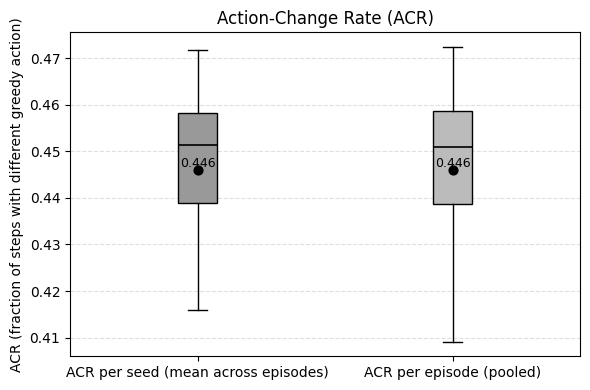

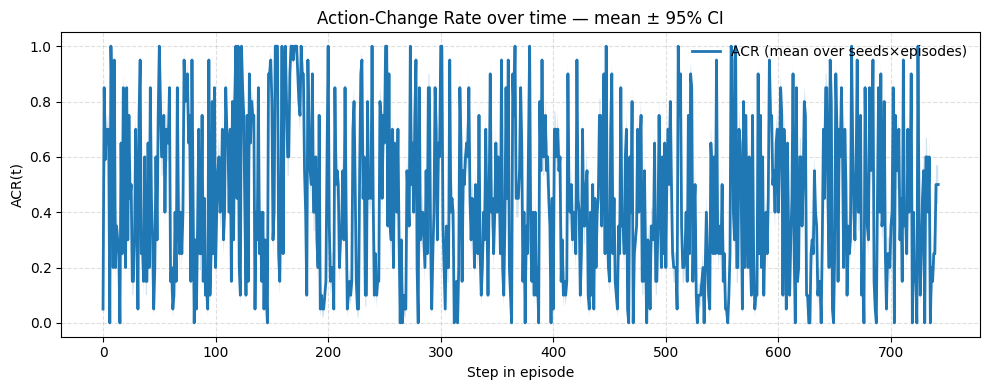

In [7]:
# ===== ACR (Action-Change Rate) – Berechnung & Plots =====
import numpy as np
import matplotlib.pyplot as plt

def _pairwise_acr(ep_actions_base, ep_actions_mask):
    """ACR je Episode: Anteil unterschiedlicher greedy Aktionen.
    Nimmt das Minimum der beiden Episodenlängen."""
    L = min(len(ep_actions_base), len(ep_actions_mask))
    if L == 0:
        return np.nan
    a = np.asarray(ep_actions_base[:L], int)
    b = np.asarray(ep_actions_mask[:L], int)
    return float(np.mean(a != b))

def _perstep_change_curve(ep_actions_base, ep_actions_mask):
    """Bool-Array der L-min Unterschiede über die Zeit für eine Episode."""
    L = min(len(ep_actions_base), len(ep_actions_mask))
    if L == 0:
        return np.array([], dtype=float)
    a = np.asarray(ep_actions_base[:L], int)
    b = np.asarray(ep_actions_mask[:L], int)
    return (a != b).astype(float)  # 1 wenn Aktion verschieden, sonst 0

# --- Daten aus dem Paket holen ---
base_actions = [np.asarray(a, int) for a in res_base_pkg["actions_disc_list"]]

# 1) Episode-weise ACR pro Seed
acr_per_seed = []   # Mittelwert ACR über Episoden je Seed
acr_all_eps  = []   # alle Episoden-ACRs aller Seeds (für Boxplot über alle)

for run in masked_runs:
    mask_actions = [np.asarray(a, int) for a in run["eval"]["actions_disc_list"]]
    # Paare nach Episodenindex (setzt gleiche EVAL_EPISODES voraus)
    ep_acrs = []
    for i in range(min(len(base_actions), len(mask_actions))):
        ep_acrs.append(_pairwise_acr(base_actions[i], mask_actions[i]))
    # Seed-Mittel
    acr_per_seed.append(np.nanmean(ep_acrs) if ep_acrs else np.nan)
    acr_all_eps.extend(ep_acrs)

acr_per_seed = np.asarray(acr_per_seed, float)
acr_all_eps  = np.asarray(acr_all_eps, float)

print(f"ACR — per seed: mean={np.nanmean(acr_per_seed):.3f}, std={np.nanstd(acr_per_seed, ddof=1):.3f}, N={np.sum(~np.isnan(acr_per_seed))}")
print(f"ACR — per episode (pooled): mean={np.nanmean(acr_all_eps):.3f}, std={np.nanstd(acr_all_eps, ddof=1):.3f}, n={np.sum(~np.isnan(acr_all_eps))}")

# 2) Per-Step ACR-Kurve (mean ± 95% CI über alle Ep x Seeds), mit Padding
def _mean_ci_perstep_change(masked_runs, base_actions):
    # sammle alle Bool-Kurven (per Episode, per Seed)
    curves = []
    for run in masked_runs:
        mask_actions = [np.asarray(a, int) for a in run["eval"]["actions_disc_list"]]
        for i in range(min(len(base_actions), len(mask_actions))):
            curves.append(_perstep_change_curve(base_actions[i], mask_actions[i]))
    if not curves:
        return None, None, None
    L = max(len(c) for c in curves)
    M = np.full((len(curves), L), np.nan, float)
    for i, c in enumerate(curves):
        M[i, :len(c)] = c
    mean = np.nanmean(M, axis=0)
    n_eff = np.sum(~np.isnan(M), axis=0).clip(min=1)
    sd = np.nanstd(M, axis=0, ddof=1)
    ci95 = 1.96 * sd / np.sqrt(n_eff)
    x = np.arange(L)
    return x, mean, ci95

x_acr, mean_acr, ci_acr = _mean_ci_perstep_change(masked_runs, base_actions)

# ---- Plot A: ACR-Verteilung (Boxplots) ----
fig, ax = plt.subplots(figsize=(6,4))
data = [acr_per_seed[~np.isnan(acr_per_seed)], acr_all_eps[~np.isnan(acr_all_eps)]]
labels = ["ACR per seed (mean across episodes)", "ACR per episode (pooled)"]
bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], ["#999999", "#bbbbbb"]):
    patch.set_facecolor(c)
for med in bp['medians']:
    med.set_color('black'); med.set_linewidth(1.2)

# Mittelwerte als Punkte + Text
means = [np.nanmean(acr_per_seed), np.nanmean(acr_all_eps)]
xpos = np.arange(1, len(data)+1)
ax.scatter(xpos, means, s=40, zorder=3, color="black")
for x, m in zip(xpos, means):
    ax.text(x, m, f"{m:.3f}", ha="center", va="bottom", fontsize=9)

ax.set_title("Action-Change Rate (ACR)")
ax.set_ylabel("ACR (fraction of steps with different greedy action)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ---- Plot B: ACR über die Zeit (mean ± 95% CI) ----
if x_acr is not None:
    plt.figure(figsize=(10,4))
    plt.plot(x_acr, mean_acr, lw=2, label="ACR (mean over seeds×episodes)")
    if ci_acr is not None and np.any(ci_acr):
        plt.fill_between(x_acr, mean_acr-ci_acr, mean_acr+ci_acr, alpha=0.2, linewidth=0)
    plt.xlabel("Step in episode")
    plt.ylabel("ACR(t)")
    plt.title("Action-Change Rate over time — mean ± 95% CI")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


##### DQN no solar

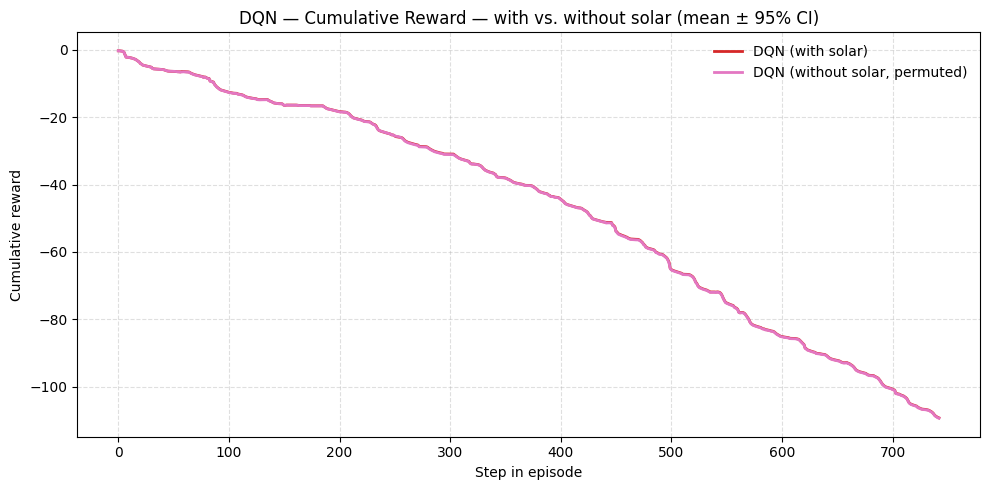

/scratch/slurm_tmpdir/job_1560401/ipykernel_2486815/822256744.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


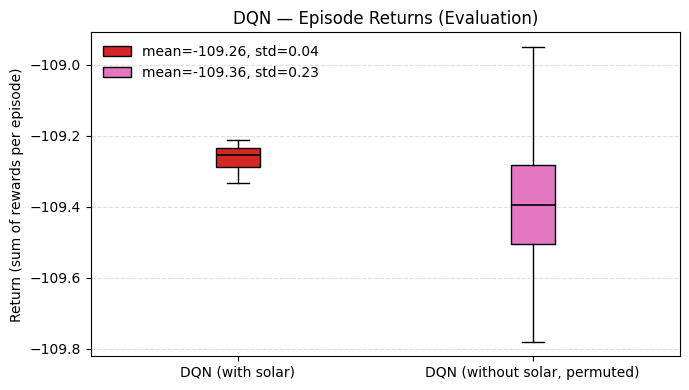

DQN (with solar)              : mean=-109.262, std=0.039, n=10
DQN (without solar, permuted) : mean=-109.361, std=0.234, n=200
ΔReturn per seed: mean=-0.102, std=0.237, N=20


In [19]:
# ----- DQN: with solar (baseline) vs. without solar (permutation across N seeds) -----

# Paths (package with {"orig":..., "masked":[...]})
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/dqn'
EVAL_FILE_WITHOUT_PRICE = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_price.pkl") 
EVAL_FILE_WITHOUT_SOLAR = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_solar.pkl") 
EVAL_FILE_WITHOUT_NET_LOAD = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_net_load.pkl") 

# Use the SOLAR package here:
MASK_PKL = EVAL_FILE_WITHOUT_SOLAR

COLOR_BASE   = "C3"  # with solar
COLOR_NOSOL  = "C6"  # without solar (permuted)

# --- Load package ---
with open(MASK_PKL, "rb") as f:
    pkg = pickle.load(f)

# Baseline (no masking) from package
res_base_pkg = pkg["orig"]
eps_base_pkg = [np.asarray(e, float) for e in res_base_pkg["ep_rewards_list"]]

# Masked runs: flatten episodes across seeds
masked_runs = pkg["masked"]
eps_mask_all = []
for run in masked_runs:
    res_mask = run["eval"]
    eps_mask_all.extend([np.asarray(e, float) for e in res_mask["ep_rewards_list"]])

# --- mean ± 95% CI cumulative rewards (min-length trim) ---
mc_base  = mean_ci_cumcurves(eps_base_pkg)
mc_nosol = mean_ci_cumcurves(eps_mask_all)
if mc_base is None or mc_nosol is None:
    raise ValueError("No episodes found in baseline or masking package.")

mean_base,  ci_base  = mc_base
mean_nosol, ci_nosol = mc_nosol

x_base  = np.arange(len(mean_base))
x_nosol = np.arange(len(mean_nosol))

# ---- Plot 1: cumulative reward (mean ± 95% CI) ----
plt.figure(figsize=(10,5))
plt.plot(x_base, mean_base, lw=2, color=COLOR_BASE, label="DQN (with solar)")
if ci_base is not None and np.any(ci_base):
    plt.fill_between(x_base, mean_base-ci_base, mean_base+ci_base, alpha=0.15, linewidth=0, color=COLOR_BASE)

plt.plot(x_nosol, mean_nosol, lw=2, color=COLOR_NOSOL, label="DQN (without solar, permuted)")
if ci_nosol is not None and np.any(ci_nosol):
    plt.fill_between(x_nosol, mean_nosol-ci_nosol, mean_nosol+ci_nosol, alpha=0.15, linewidth=0, color=COLOR_NOSOL)

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("DQN — Cumulative Reward — with vs. without solar (mean ± 95% CI)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---- Plot 2: Episode-Returns (Boxplot) ----
fig, ax = plt.subplots(figsize=(7,4))
data   = [ret_base, ret_nosol]
labels = ["DQN (with solar)", "DQN (without solar, permuted)"]
colors = [COLOR_BASE, COLOR_NOSOL]

bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(c)
for med in bp['medians']:
    med.set_color('black'); med.set_linewidth(1.2)

# Legendeneinträge mit mean ± std (ohne n)
m_base, s_base   = float(ret_base.mean()),  float(ret_base.std(ddof=1))
m_nosol, s_nosol = float(ret_nosol.mean()), float(ret_nosol.std(ddof=1))

import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor=COLOR_BASE,  edgecolor='black',
                   label=f"mean={m_base:.2f}, std={s_base:.2f}"),
    mpatches.Patch(facecolor=COLOR_NOSOL, edgecolor='black',
                   label=f"mean={m_nosol:.2f}, std={s_nosol:.2f}"),
]
ax.legend(handles=legend_handles, frameon=False, loc="best")

ax.set_title("DQN — Episode Returns (Evaluation)")
ax.set_ylabel("Return (sum of rewards per episode)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


print(f"DQN (with solar)              : mean={ret_base.mean():.3f}, std={ret_base.std(ddof=1):.3f}, n={ret_base.size}")
print(f"DQN (without solar, permuted) : mean={ret_nosol.mean():.3f}, std={ret_nosol.std(ddof=1):.3f}, n={ret_nosol.size}")

# ΔReturn per seed (mean over episodes per seed)
seed_deltas = []
base_ep_returns = episode_returns(eps_base_pkg)
base_mean = float(base_ep_returns.mean())

for run in masked_runs:
    ep_mask = [np.asarray(e, float) for e in run["eval"]["ep_rewards_list"]]
    seed_deltas.append(float(episode_returns(ep_mask).mean() - base_mean))

seed_deltas = np.asarray(seed_deltas, float)
print(f"ΔReturn per seed: mean={seed_deltas.mean():.3f}, std={seed_deltas.std(ddof=1):.3f}, N={len(seed_deltas)}")


##### DQN no net_load

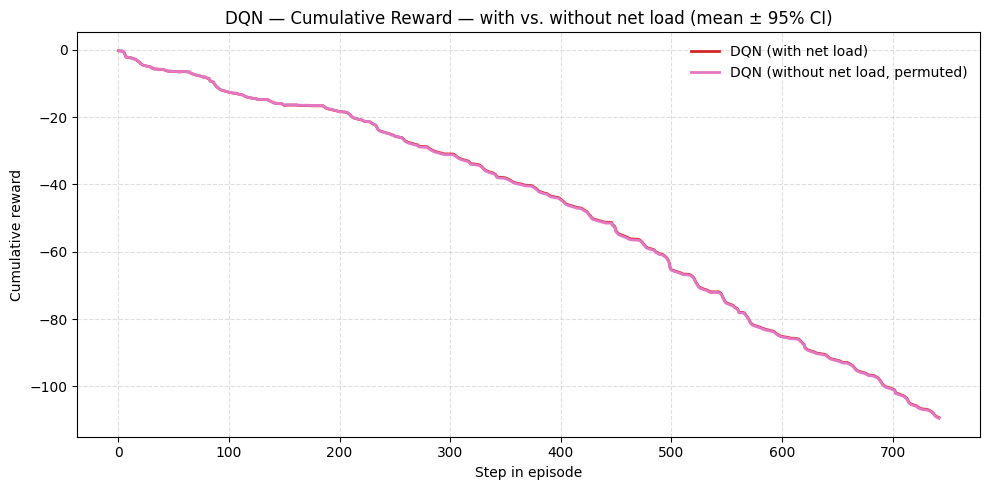

/scratch/slurm_tmpdir/job_1560401/ipykernel_2486815/912741159.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


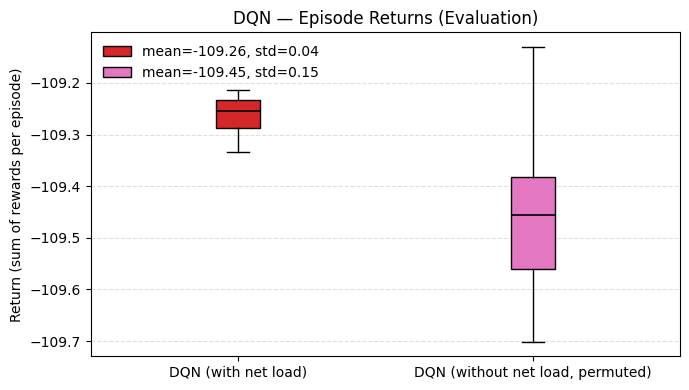

DQN (with net load)              : mean=-109.262, std=0.039, n=10
DQN (without net load, permuted) : mean=-109.447, std=0.149, n=200
ΔReturn per seed: mean=-0.171, std=0.148, N=20


In [16]:
# ----- DQN: with net load (baseline) vs. without net load (permutation across N seeds) -----

# Paths (package with {"orig":..., "masked":[...]})
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/dqn'
EVAL_FILE_WITHOUT_PRICE    = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_price.pkl") 
EVAL_FILE_WITHOUT_SOLAR    = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_solar.pkl") 
EVAL_FILE_WITHOUT_NET_LOAD = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_net_load.pkl") 

# Use the NET LOAD package here:
MASK_PKL = EVAL_FILE_WITHOUT_NET_LOAD

COLOR_BASE  = "C3"  # with net load
COLOR_NONET = "C6"  # without net load (permuted)

# --- Load package ---
with open(MASK_PKL, "rb") as f:
    pkg = pickle.load(f)

# Baseline (no masking) from package
res_base_pkg = pkg["orig"]
eps_base_pkg = [np.asarray(e, float) for e in res_base_pkg["ep_rewards_list"]]

# Masked runs: flatten episodes across seeds
masked_runs = pkg["masked"]
eps_mask_all = []
for run in masked_runs:
    res_mask = run["eval"]
    eps_mask_all.extend([np.asarray(e, float) for e in res_mask["ep_rewards_list"]])

# --- mean ± 95% CI cumulative rewards (min-length trim) ---
mc_base  = mean_ci_cumcurves(eps_base_pkg)
mc_nonet = mean_ci_cumcurves(eps_mask_all)
if mc_base is None or mc_nonet is None:
    raise ValueError("No episodes found in baseline or masking package.")

mean_base,  ci_base  = mc_base
mean_nonet, ci_nonet = mc_nonet

x_base  = np.arange(len(mean_base))
x_nonet = np.arange(len(mean_nonet))

# ---- Plot 1: cumulative reward (mean ± 95% CI) ----
plt.figure(figsize=(10,5))
plt.plot(x_base, mean_base, lw=2, color=COLOR_BASE, label="DQN (with net load)")
if ci_base is not None and np.any(ci_base):
    plt.fill_between(x_base, mean_base-ci_base, mean_base+ci_base, alpha=0.15, linewidth=0, color=COLOR_BASE)

plt.plot(x_nonet, mean_nonet, lw=2, color=COLOR_NONET, label="DQN (without net load, permuted)")
if ci_nonet is not None and np.any(ci_nonet):
    plt.fill_between(x_nonet, mean_nonet-ci_nonet, mean_nonet+ci_nonet, alpha=0.15, linewidth=0, color=COLOR_NONET)

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("DQN — Cumulative Reward — with vs. without net load (mean ± 95% CI)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---- Plot 2: Episode-Returns (Boxplot) ----
fig, ax = plt.subplots(figsize=(7,4))
data   = [ret_base, ret_nonet]
labels = ["DQN (with net load)", "DQN (without net load, permuted)"]
colors = [COLOR_BASE, COLOR_NONET]

bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(c)
for med in bp['medians']:
    med.set_color('black'); med.set_linewidth(1.2)

# Legend entries with mean ± std (no n)
m_base, s_base   = float(ret_base.mean()),  float(ret_base.std(ddof=1))
m_nonet, s_nonet = float(ret_nonet.mean()), float(ret_nonet.std(ddof=1))

import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor=COLOR_BASE,  edgecolor='black',
                   label=f"mean={m_base:.2f}, std={s_base:.2f}"),
    mpatches.Patch(facecolor=COLOR_NONET, edgecolor='black',
                   label=f"mean={m_nonet:.2f}, std={s_nonet:.2f}"),
]
ax.legend(handles=legend_handles, frameon=False, loc="best")

ax.set_title("DQN — Episode Returns (Evaluation)")
ax.set_ylabel("Return (sum of rewards per episode)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


print(f"DQN (with net load)              : mean={ret_base.mean():.3f}, std={ret_base.std(ddof=1):.3f}, n={ret_base.size}")
print(f"DQN (without net load, permuted) : mean={ret_nonet.mean():.3f}, std={ret_nonet.std(ddof=1):.3f}, n={ret_nonet.size}")

# ΔReturn per seed (mean over episodes per seed)
seed_deltas = []
base_ep_returns = episode_returns(eps_base_pkg)
base_mean = float(base_ep_returns.mean())

for run in masked_runs:
    ep_mask = [np.asarray(e, float) for e in run["eval"]["ep_rewards_list"]]
    seed_deltas.append(float(episode_returns(ep_mask).mean() - base_mean))

seed_deltas = np.asarray(seed_deltas, float)
print(f"ΔReturn per seed: mean={seed_deltas.mean():.3f}, std={seed_deltas.std(ddof=1):.3f}, N={len(seed_deltas)}")


##### DQN no price and net_load

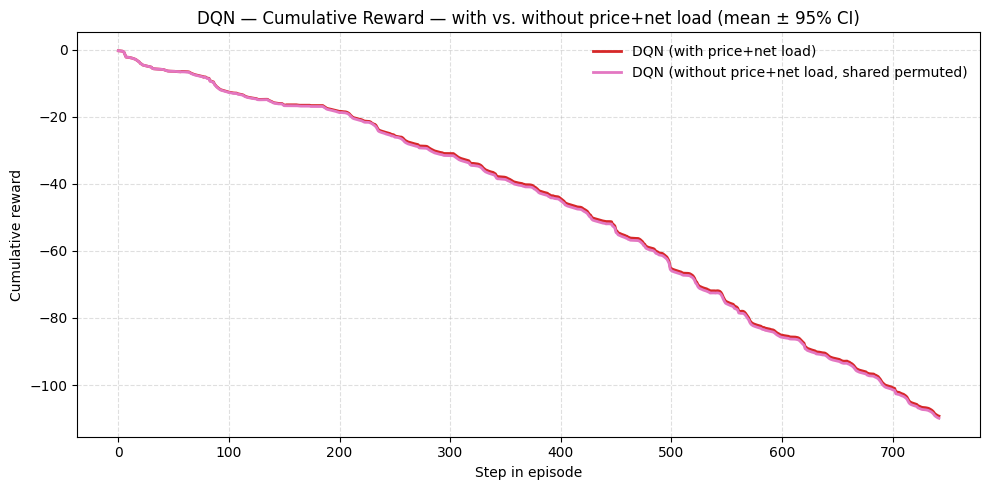

/scratch/slurm_tmpdir/job_1560401/ipykernel_2486815/3083158433.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


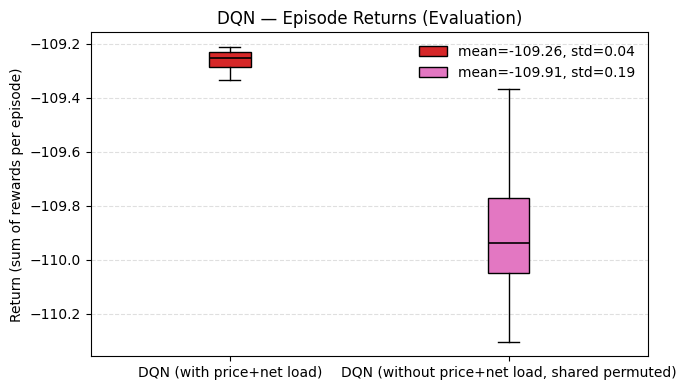

DQN (with price+net load)              : mean=-109.262, std=0.039, n=10
DQN (without price+net load, shared permuted): mean=-109.910, std=0.190, n=200
ΔReturn per seed: mean=-0.636, std=0.190, N=20


In [18]:
# ----- DQN: with price+net load (baseline) vs. without price+net load (permutation across N seeds) -----

# Paths (package with {"orig":..., "masked":[...]})
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/dqn'
EVAL_FILE_WITHOUT_PRICE_AND_NET_LOAD = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_price_and_net_load.pkl")

MASK_PKL = EVAL_FILE_WITHOUT_PRICE_AND_NET_LOAD

COLOR_BASE = "C3"  # with price+net load
COLOR_NOPL = "C6"  # without price+net load (permuted)

# --- Load package ---
with open(MASK_PKL, "rb") as f:
    pkg = pickle.load(f)

# Optional: shared/separate info aus dem Paket lesen (falls vorhanden)
_perm_mode = None
try:
    _shared_flag = pkg.get("setup", {}).get("shared_perm", None)
    if _shared_flag is True:
        _perm_mode = "shared"
    elif _shared_flag is False:
        _perm_mode = "separate"
except Exception:
    pass

# Baseline (no masking) from package
res_base_pkg = pkg["orig"]
eps_base_pkg = [np.asarray(e, float) for e in res_base_pkg["ep_rewards_list"]]

# Masked runs: flatten episodes across seeds
masked_runs = pkg["masked"]
eps_mask_all = []
for run in masked_runs:
    res_mask = run["eval"]
    eps_mask_all.extend([np.asarray(e, float) for e in res_mask["ep_rewards_list"]])

# --- mean ± 95% CI cumulative rewards (min-length trim) ---
mc_base = mean_ci_cumcurves(eps_base_pkg)
mc_noplnl = mean_ci_cumcurves(eps_mask_all)
if mc_base is None or mc_noplnl is None:
    raise ValueError("No episodes found in baseline or masking package.")

mean_base,  ci_base   = mc_base
mean_noplnl, ci_noplnl = mc_noplnl

x_base  = np.arange(len(mean_base))
x_noplnl = np.arange(len(mean_noplnl))

# Legenden-Text für Masking-Linie
if _perm_mode is None:
    label_mask = "DQN (without price+net load, permuted)"
else:
    label_mask = f"DQN (without price+net load, { _perm_mode } permuted)"

# ---- Plot 1: cumulative reward (mean ± 95% CI) ----
plt.figure(figsize=(10,5))
plt.plot(x_base, mean_base, lw=2, color=COLOR_BASE, label="DQN (with price+net load)")
if ci_base is not None and np.any(ci_base):
    plt.fill_between(x_base, mean_base-ci_base, mean_base+ci_base, alpha=0.15, linewidth=0, color=COLOR_BASE)

plt.plot(x_noplnl, mean_noplnl, lw=2, color=COLOR_NOPL, label=label_mask)
if ci_noplnl is not None and np.any(ci_noplnl):
    plt.fill_between(x_noplnl, mean_noplnl-ci_noplnl, mean_noplnl+ci_noplnl, alpha=0.15, linewidth=0, color=COLOR_NOPL)

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("DQN — Cumulative Reward — with vs. without price+net load (mean ± 95% CI)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---- Plot 2: Episode-Returns (Boxplot) ----
fig, ax = plt.subplots(figsize=(7,4))
data   = [ret_base, ret_noplnl]
labels = ["DQN (with price+net load)", label_mask]
colors = [COLOR_BASE, COLOR_NOPL]

bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(c)
for med in bp['medians']:
    med.set_color('black'); med.set_linewidth(1.2)

# Legendeneinträge mit mean ± std (ohne n)
m_base, s_base     = float(ret_base.mean()),   float(ret_base.std(ddof=1))
m_noplnl, s_noplnl = float(ret_noplnl.mean()), float(ret_noplnl.std(ddof=1))

import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor=COLOR_BASE,  edgecolor='black',
                   label=f"mean={m_base:.2f}, std={s_base:.2f}"),
    mpatches.Patch(facecolor=COLOR_NOPL, edgecolor='black',
                   label=f"mean={m_noplnl:.2f}, std={s_noplnl:.2f}"),
]
ax.legend(handles=legend_handles, frameon=False, loc="best")

ax.set_title("DQN — Episode Returns (Evaluation)")
ax.set_ylabel("Return (sum of rewards per episode)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"DQN (with price+net load)              : mean={ret_base.mean():.3f}, std={ret_base.std(ddof=1):.3f}, n={ret_base.size}")
print(f"{label_mask:40s}: mean={ret_noplnl.mean():.3f}, std={ret_noplnl.std(ddof=1):.3f}, n={ret_noplnl.size}")

# ΔReturn per seed (mean over episodes per seed)
seed_deltas = []
base_ep_returns = episode_returns(eps_base_pkg)
base_mean = float(base_ep_returns.mean())
for run in masked_runs:
    ep_mask = [np.asarray(e, float) for e in run["eval"]["ep_rewards_list"]]
    seed_deltas.append(float(episode_returns(ep_mask).mean() - base_mean))
seed_deltas = np.asarray(seed_deltas, float)
print(f"ΔReturn per seed: mean={seed_deltas.mean():.3f}, std={seed_deltas.std(ddof=1):.3f}, N={len(seed_deltas)}")


##### Feature Removal (old)

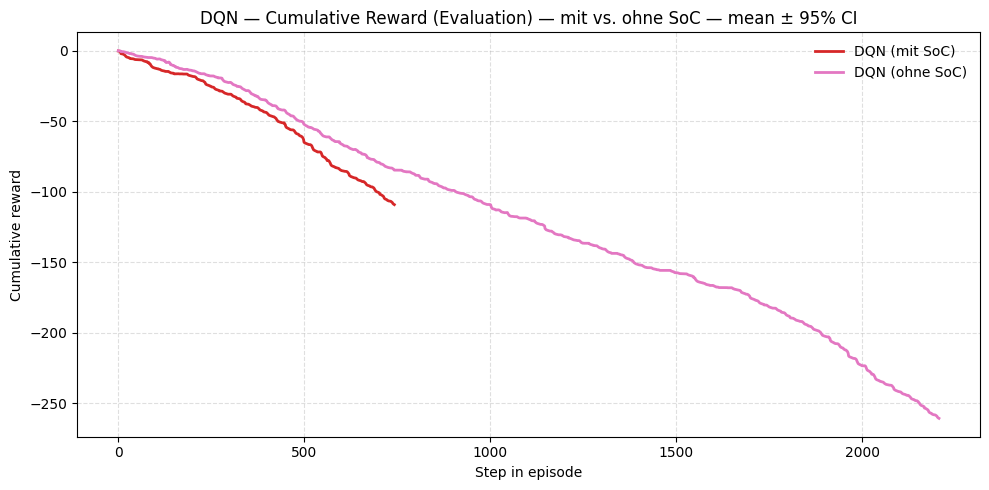

/scratch/slurm_tmpdir/job_1559397/ipykernel_1845133/2547240291.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


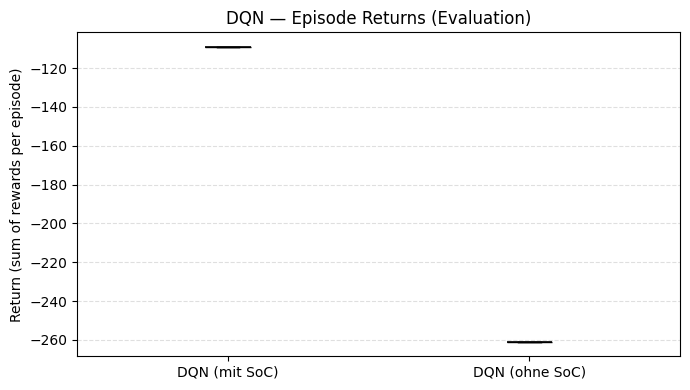

DQN (mit SoC)   : mean=-109.270, std=0.031, n=10
DQN (ohne SoC)  : mean=-260.859, std=0.000, n=10


In [4]:
# ----- DQN: normal vs. without SoC -----

DQN_EVAL_FILE_BASE   = DQN_EVAL_FILE  
DQN_EVAL_FILE_NOSOC  = r'/hkfs/home/haicore/iai/cj9272/logs/dqn/dqn_eval_10episodes_1seed_without_soc.pkl'

COLOR_BASE  = "C3"  
COLOR_NOSOC = "C6"  

eps_base  = all_episode_step_rewards_from_pkl(DQN_EVAL_FILE_BASE)
eps_nosoc = all_episode_step_rewards_from_pkl(DQN_EVAL_FILE_NOSOC)

# mean ± 95% CI der kumulativen Rewards (auf min-Länge getrimmt)
mc_base   = mean_ci_cumcurves(eps_base)
mc_nosoc  = mean_ci_cumcurves(eps_nosoc)
if mc_base is None or mc_nosoc is None:
    raise ValueError("Keine Episoden gefunden in einem der DQN-Eval-Files.")
mean_base, ci_base   = mc_base
mean_nosoc, ci_nosoc = mc_nosoc

x_base  = np.arange(len(mean_base))
x_nosoc = np.arange(len(mean_nosoc))

# ---- Plot 1: cumulative reward (mean ± 95% CI) ----
plt.figure(figsize=(10,5))
plt.plot(x_base,  mean_base,  lw=2, color=COLOR_BASE,  label="DQN (mit SoC)")
if ci_base is not None and np.any(ci_base):
    plt.fill_between(x_base, mean_base-ci_base, mean_base+ci_base, alpha=0.15, linewidth=0, color=COLOR_BASE)

plt.plot(x_nosoc, mean_nosoc, lw=2, color=COLOR_NOSOC, label="DQN (ohne SoC)")
if ci_nosoc is not None and np.any(ci_nosoc):
    plt.fill_between(x_nosoc, mean_nosoc-ci_nosoc, mean_nosoc+ci_nosoc, alpha=0.15, linewidth=0, color=COLOR_NOSOC)

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("DQN — Cumulative Reward (Evaluation) — mit vs. ohne SoC — mean ± 95% CI")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---- Plot 2: Episode-Returns (Boxplot) ----
ret_base  = episode_returns(eps_base)
ret_nosoc = episode_returns(eps_nosoc)

fig, ax = plt.subplots(figsize=(7,4))
data   = [ret_base, ret_nosoc]
labels = ["DQN (mit SoC)", "DQN (ohne SoC)"]
colors = [COLOR_BASE, COLOR_NOSOC]
bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(c)
for med in bp['medians']:
    med.set_color('black'); med.set_linewidth(1.2)
ax.set_title("DQN — Episode Returns (Evaluation)")
ax.set_ylabel("Return (sum of rewards per episode)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"DQN (mit SoC)   : mean={ret_base.mean():.3f}, std={ret_base.std(ddof=1):.3f}, n={ret_base.size}")
print(f"DQN (ohne SoC)  : mean={ret_nosoc.mean():.3f}, std={ret_nosoc.std(ddof=1):.3f}, n={ret_nosoc.size}")

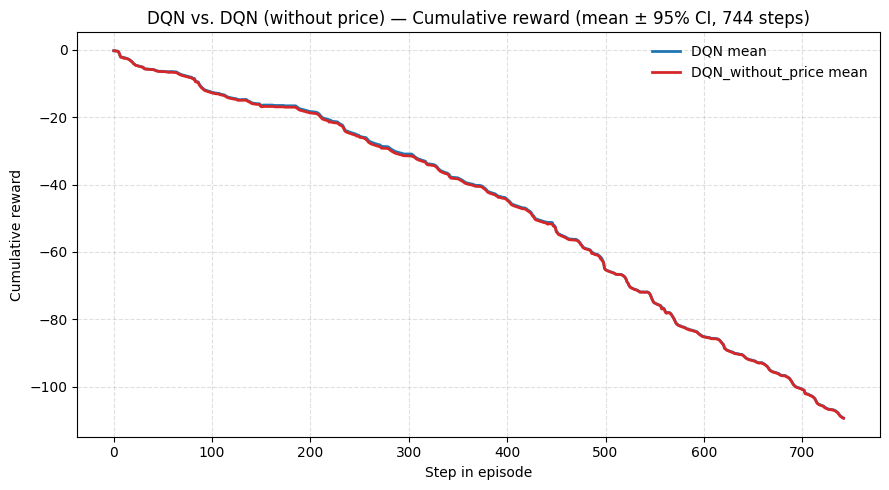

DQN                 mean=-109.27  std=0.03  n=10
DQN_without_price   mean=-109.38  std=0.03  n=10


In [8]:
# --- Pfade ---
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/dqn'
DQN_EVAL_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/dqn/dqn_split_10eval_final_not_deterministic.pkl'
EVAL_FILE_WITHOUT_PRICE = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_price.pkl")

# --- Loader: identisch wie bei DQN ---
import os, pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def all_episode_step_rewards_from_pkl(path):
    """Erwartet ein Pickle mit Schlüssel 'ep_rewards_list' (Liste np.ndarray pro Episode)."""
    with open(path, "rb") as f:
        data = pickle.load(f)
    # kompatibel zu deinem eval_dqn-Output
    if isinstance(data, dict) and "ep_rewards_list" in data:
        return [np.asarray(ep, float) for ep in data["ep_rewards_list"]]
    # fallback: direkt Liste
    if isinstance(data, list):
        return [np.asarray(ep, float) for ep in data]
    raise ValueError(f"Unbekanntes PKL-Format: {path}")

# --- Laden & auf 744 Schritte kappen ---
def cap_steps(list_of_step_rewards, max_steps):
    return [np.asarray(r, float)[:max_steps] for r in list_of_step_rewards]

def mean_ci_cumcurves_pad(list_of_step_rewards):
    if not list_of_step_rewards:
        return None, None, None
    L = max(len(r) for r in list_of_step_rewards)
    M = np.full((len(list_of_step_rewards), L), np.nan, float)
    for i, r in enumerate(list_of_step_rewards):
        M[i, :len(r)] = np.cumsum(r)
    mean = np.nanmean(M, axis=0)
    n_eff = np.sum(~np.isnan(M), axis=0).clip(min=1)
    sd   = np.nanstd(M, axis=0, ddof=1)
    ci95 = 1.96 * sd / np.sqrt(n_eff)
    x = np.arange(L)
    return x, mean, ci95

MONTH_SLICES = {
    "train": (0, 1463),
    "test":  (1464, 2207),
}
EVAL_MAX_STEPS = MONTH_SLICES["test"][1] - MONTH_SLICES["test"][0] + 1  # 744

models_2 = {}
if Path(DQN_EVAL_FILE).exists():
    dqn_steps = cap_steps(all_episode_step_rewards_from_pkl(DQN_EVAL_FILE), EVAL_MAX_STEPS)
    models_2["DQN"] = dqn_steps
else:
    print(f"[Warn] fehlt: {DQN_EVAL_FILE}")

if Path(EVAL_FILE_WITHOUT_PRICE).exists():
    dqn_wo_steps = cap_steps(all_episode_step_rewards_from_pkl(EVAL_FILE_WITHOUT_PRICE), EVAL_MAX_STEPS)
    models_2["DQN_without_price"] = dqn_wo_steps
else:
    print(f"[Warn] fehlt: {EVAL_FILE_WITHOUT_PRICE}")

# --- Plot: cumulative reward mean ± 95% CI (744 steps) ---
plt.figure(figsize=(9, 5))

# Farben (fallback, falls du kein COLOR-Dict hast)
local_color = {
    "DQN": "#1f77b4",
    "DQN_without_price": "#d62728",
}
order = ["DQN", "DQN_without_price"]

for name in order:
    if name not in models_2:
        continue
    x, mean, ci = mean_ci_cumcurves_pad(models_2[name])
    L = min(len(x), EVAL_MAX_STEPS)
    x, mean = x[:L], mean[:L]
    ci = (ci[:L] if ci is not None else None)
    c = local_color.get(name, None)
    plt.plot(x, mean, lw=2, label=f"{name} mean", color=c)
    if ci is not None and np.any(ci):
        plt.fill_between(x, mean-ci, mean+ci, alpha=0.18, linewidth=0, color=c)

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("DQN vs. DQN (without price) — Cumulative reward (mean ± 95% CI, 744 steps)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- Kennzahlen drucken (Episoden-Return mean ± std) ---
def _episode_returns(step_lists):
    return np.array([np.sum(s) for s in step_lists], float)

for name in order:
    if name not in models_2:
        continue
    rets = _episode_returns(models_2[name])
    if rets.size:
        print(f"{name:18s}  mean={rets.mean():.2f}  std={rets.std(ddof=1):.2f}  n={rets.size}")
